In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [12]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [13]:
# Choose which elements to search on
elts = elts_pert

In [14]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [15]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [16]:
# Review nearest asteroid to these candidate elements
# elts_near

In [17]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [18]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [19]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [20]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [21]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [22]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [23]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [24]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [25]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [26]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [27]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [28]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
optimizer_type = 'adam'

In [29]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, 
                ztf_elt=ztf_elt, 
                site_name=site_name, 
                thresh_deg=thresh_deg,
                optimizer_type=optimizer_type,
                learning_rate=learning_rate, 
                clipnorm=clipnorm,
                name='model')

In [30]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     1.19  :   0.00 :  1799.79 :  7200.00
Mean     :     1.19  :   0.00 :  1799.79 :  7200.00
Median   :     0.83  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.45  :   0.00 :  1799.77 :  7200.99
Min      :    -1.44  :   0.00 :  1792.82 :  7200.00
Max      :     6.47  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 3200 samples
Epoch 1/4
3200/3200 [==============================] - 3s 830us/sample - loss: -56386.4428
Epoch 2/4
3200/3200 [==============================] - 1s 378us/sample - loss: -72274.9776
Epoch 3/4
3200/3200 [==============================] - 1s 370us/sample - loss: -92628.0195
Epoch 4/4
3200/3200 [==============================] - 1s 360us/sample - loss: -119757.2427
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1698.60 :  1698.60 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      3.27 :     3.27 :      nan
Mean Hits           :      0.0

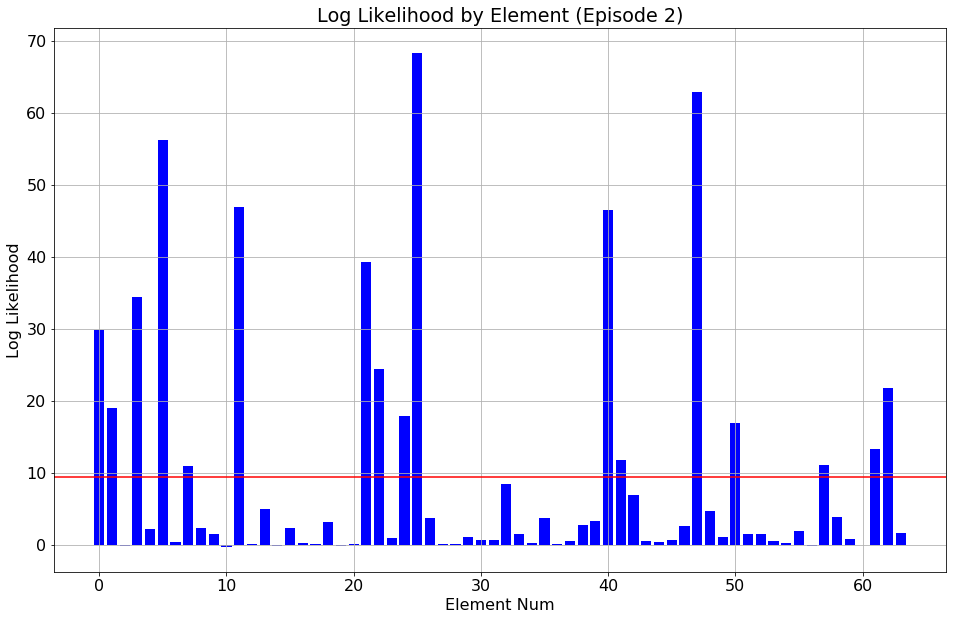

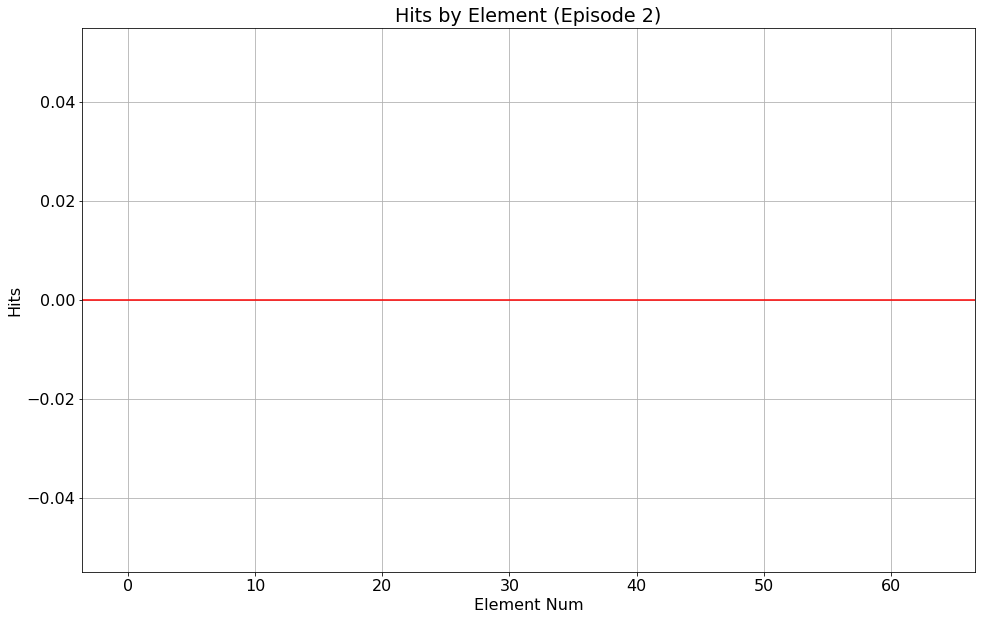


********************************************************************************
Round 2: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    400
effective_learning_rate=1.526e-05, training_time 18 sec.
Train on 3200 samples
Epoch 9/12
3200/3200 [==============================] - 4s 1ms/sample - loss: -685798.9775
Epoch 10/12
3200/3200 [==============================] - 2s 501us/sample - loss: -771232.9587
Epoch 11/12
3200/3200 [==============================] - 2s 500us/sample - loss: -797426.1437
Epoch 12/12
3200/3200 [==============================] - 2s 486us/sample - loss: -817039.8612
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1456.84 :  1456.84 :      nan arc seconds
Geom Mean Threshold :   7195.35 :  7195.35 :      nan arc seconds
Mean Log Likelihood :     19.63 :

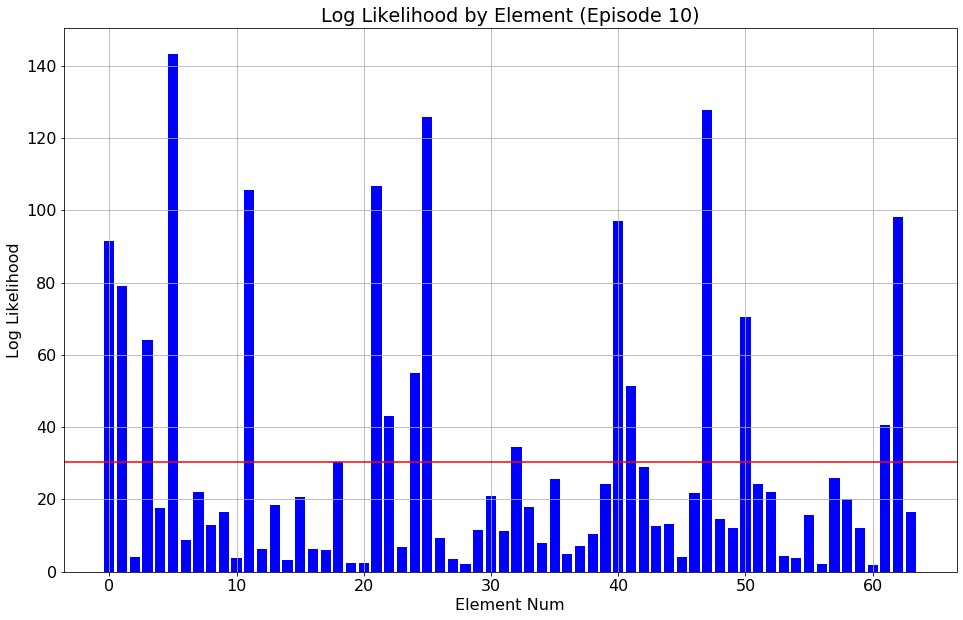

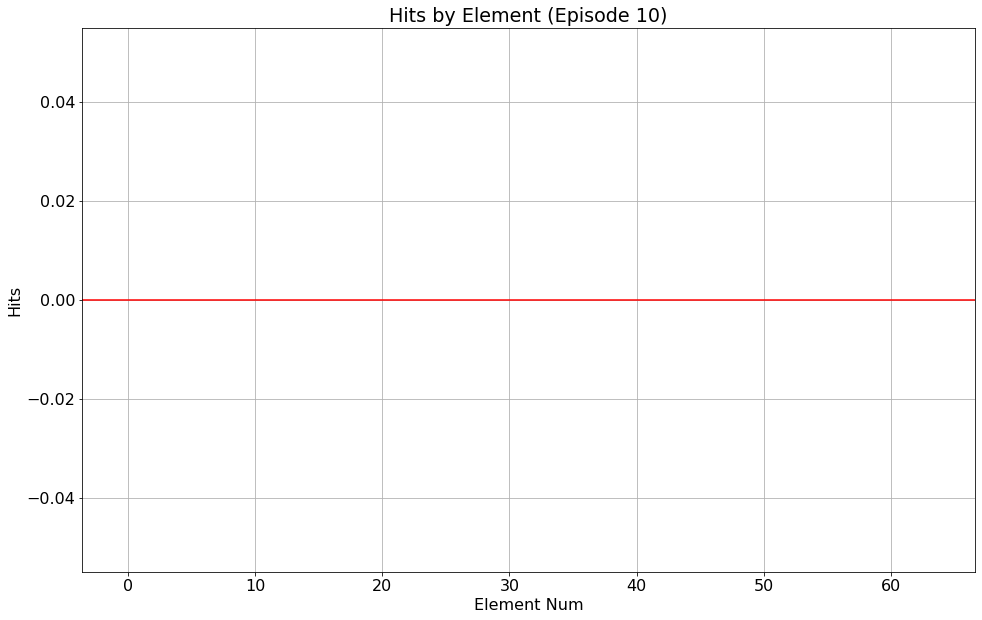


********************************************************************************
Round 3: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2000
effective_learning_rate=1.490e-05, training_time 84 sec.
Train on 3200 samples
Epoch 41/44
3200/3200 [==============================] - 3s 933us/sample - loss: -2094453.5325
Epoch 42/44
3200/3200 [==============================] - 1s 414us/sample - loss: -2796742.3850
Epoch 43/44
3200/3200 [==============================] - 1s 413us/sample - loss: -3914661.9250
Epoch 44/44
3200/3200 [==============================] - 1s 407us/sample - loss: -5736704.0500
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    801.06 :   801.06 :      nan arc seconds
Geom Mean Threshold :   5060.89 :  5060.89 :      nan arc seconds
Mean Log Likelihood :     53.01 :    53.01 :      nan
Mean Hits    

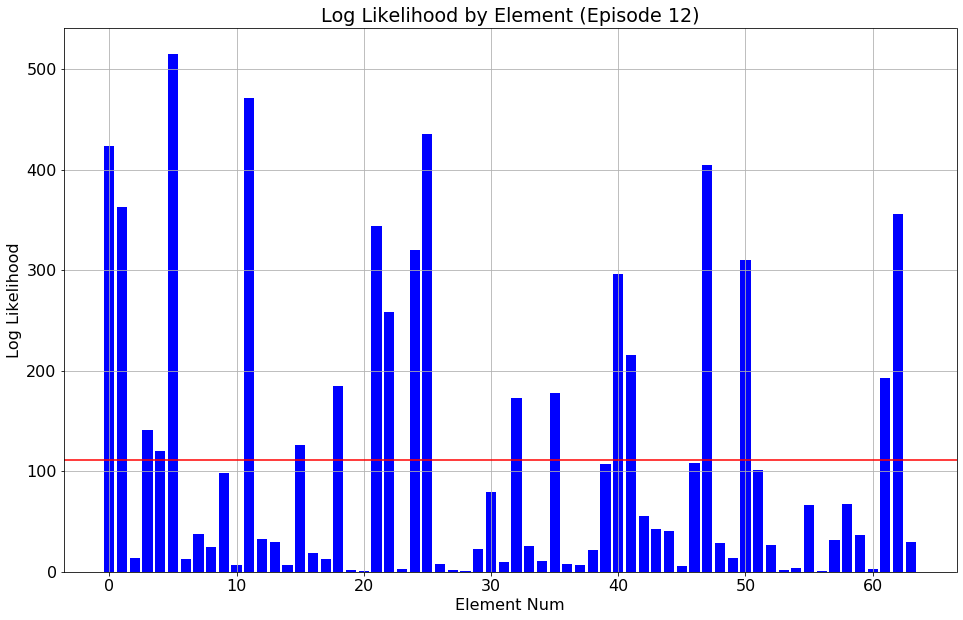

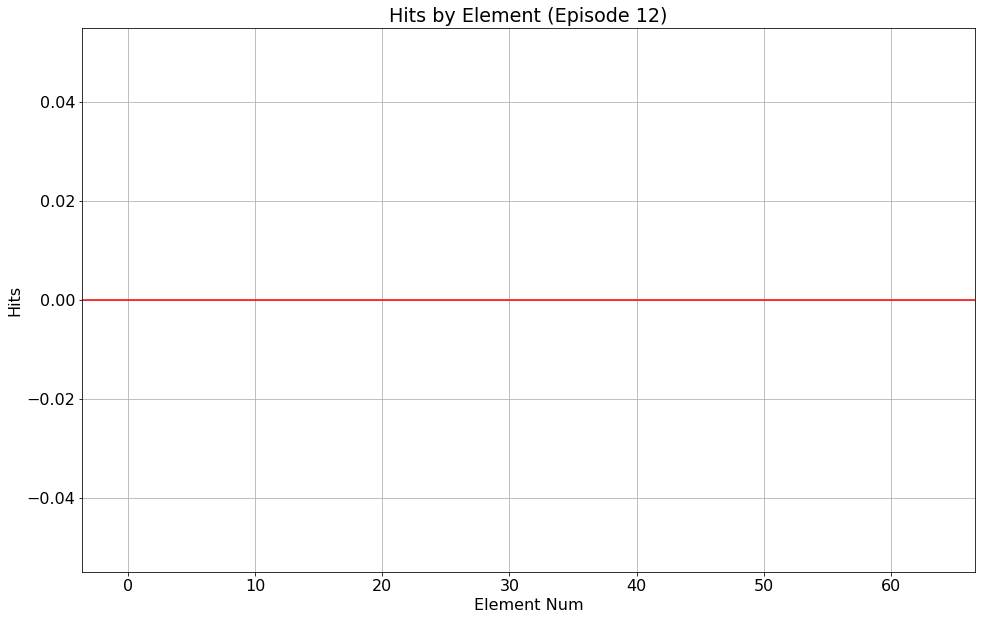


********************************************************************************
Round 4: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   2400
effective_learning_rate=1.490e-05, training_time 98 sec.
Train on 3200 samples
Epoch 49/52
3200/3200 [==============================] - 4s 1ms/sample - loss: -53646996.0800
Epoch 50/52
3200/3200 [==============================] - 2s 546us/sample - loss: -55240112.2400
Epoch 51/52
3200/3200 [==============================] - 2s 539us/sample - loss: -56177901.8400
Epoch 52/52
3200/3200 [==============================] - 2s 549us/sample - loss: -57108275.8400
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    507.42 :   507.42 :      nan arc seconds
Geom Mean Threshold :   4236.59 :  4236.59 :      nan arc seconds
Mean Log Likelihood :  

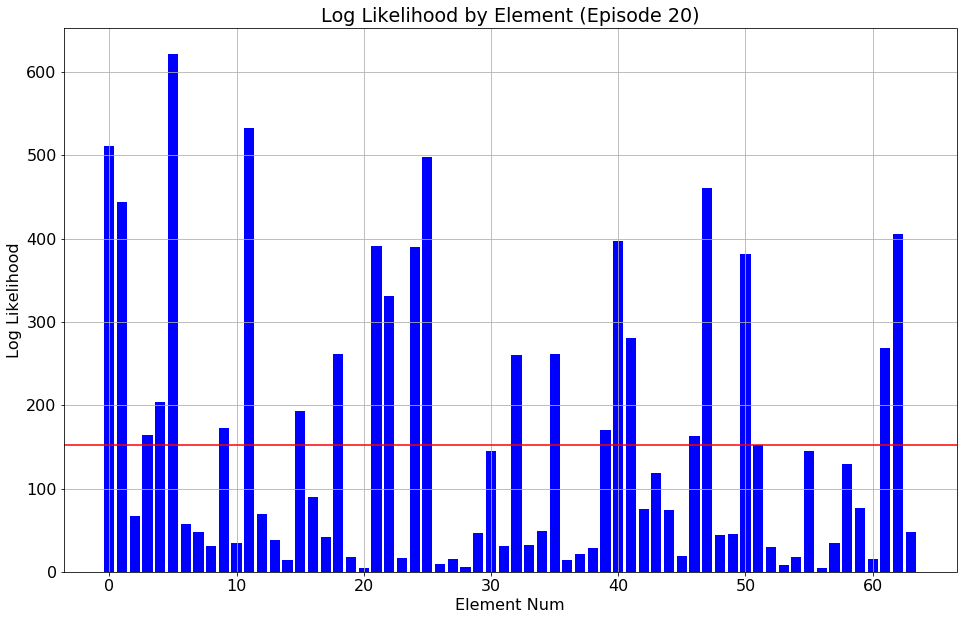

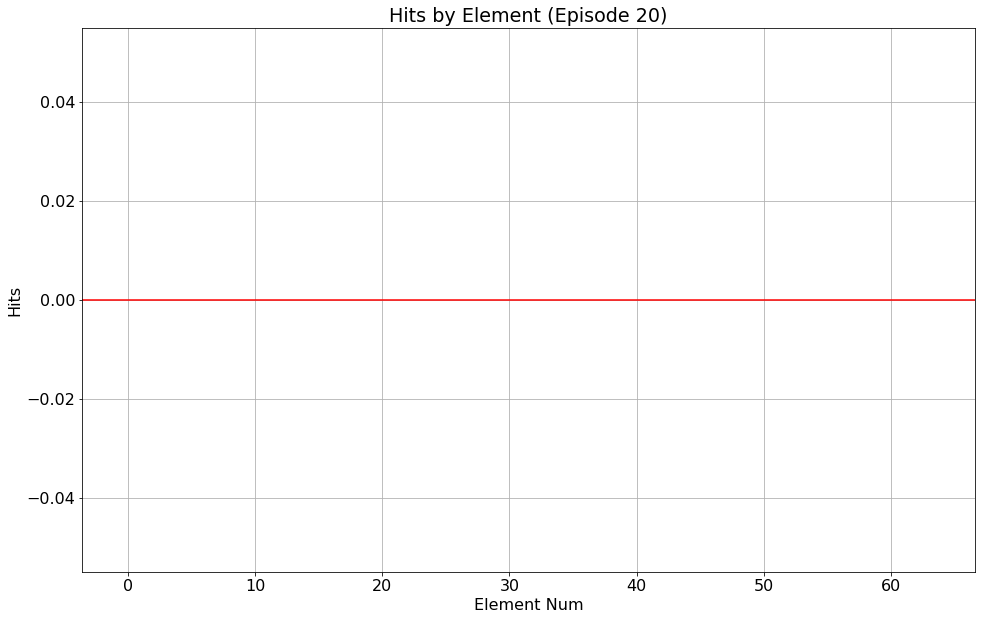


********************************************************************************
Round 5: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   4000
effective_learning_rate=1.467e-05, training_time 168 sec.
Train on 3200 samples
Epoch 81/84
3200/3200 [==============================] - 3s 879us/sample - loss: -102453738.0800
Epoch 82/84
3200/3200 [==============================] - 1s 451us/sample - loss: -126469905.1200
Epoch 83/84
3200/3200 [==============================] - 1s 450us/sample - loss: -158729882.8800
Epoch 84/84
3200/3200 [==============================] - 1s 434us/sample - loss: -203104715.2000
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    291.41 :   291.41 :      nan arc seconds
Geom Mean Threshold :   2558.16 :  2558.16 :      nan arc seconds
Mean Log Likelihood :    202.05 :   202.05 :      nan
Mean

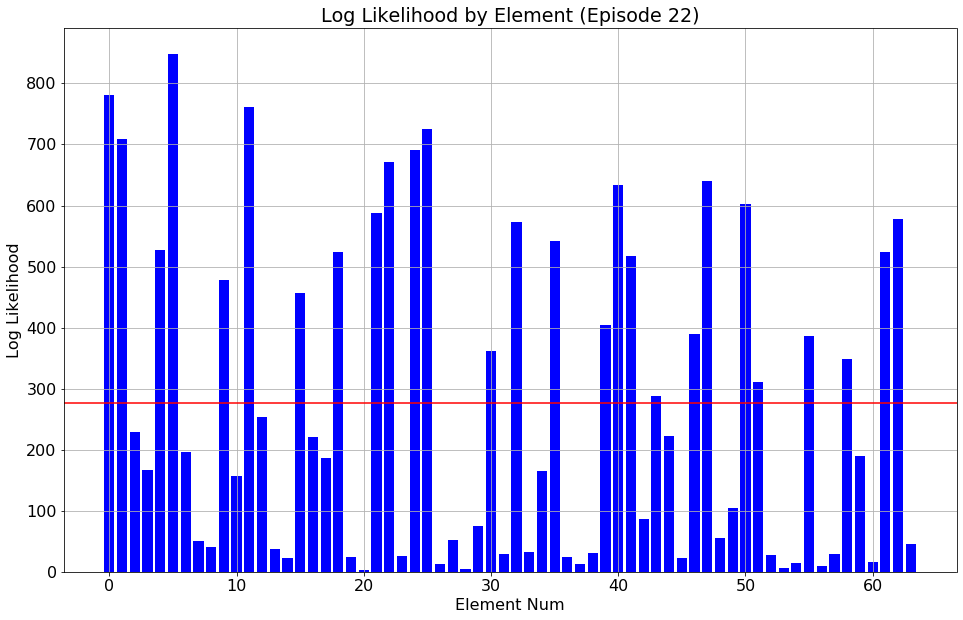

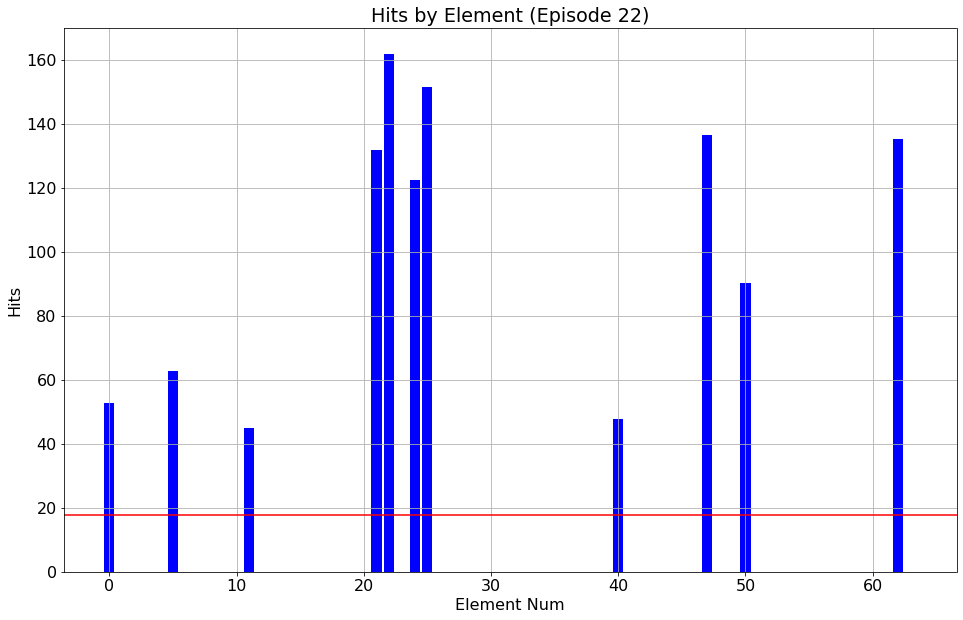


********************************************************************************
Round 6: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   4400
effective_learning_rate=2.384e-04, training_time 184 sec.
Train on 3200 samples
Epoch 89/92
3200/3200 [==============================] - 4s 1ms/sample - loss: inf
Adjusted element weight down on 8 candidate elements. Mean weight = 9.07e-01
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    193.44 :   265.56 :    42.03 arc seconds
Geom Mean Threshold :   1907.46 :  2376.72 :   661.01 arc seconds
Mean Log Likelihood :    281.81 :   198.00 :   685.62
Mean Hits           :     19.13 :     0.00 :   111.32
Good Elements       :     11.00

Training episode 23: Epoch   89, Batch   4450
effective_learning_rate=1.383e-05, training_time 189 sec

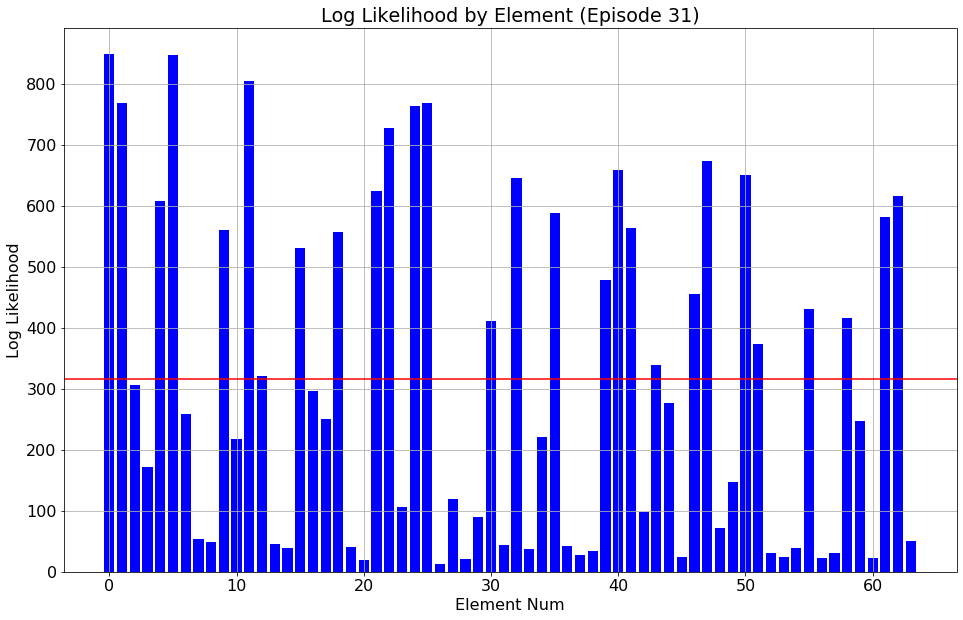

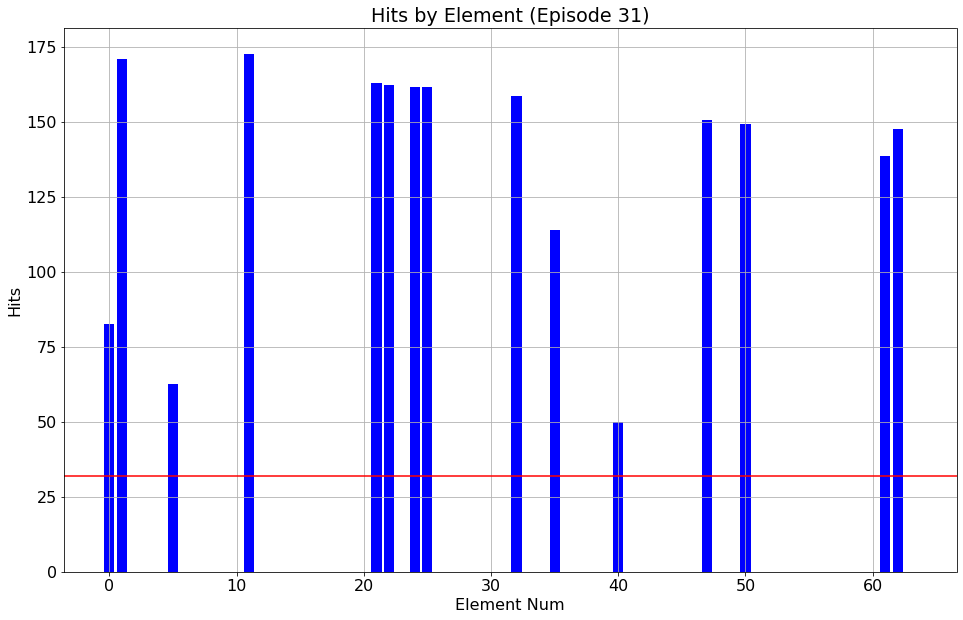


********************************************************************************
Round 7: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3000.0
********************************************************************************

Training episode 31: Epoch  121, Batch   6050
effective_learning_rate=2.441e-04, training_time 261 sec.
Train on 3200 samples
Epoch 122/125
3200/3200 [==============================] - 3s 918us/sample - loss: -1264493808.6400
Epoch 123/125
3200/3200 [==============================] - 2s 509us/sample - loss: -1505023357.4400
Epoch 124/125
3200/3200 [==============================] - 2s 491us/sample - loss: -1808798466.5600
Epoch 125/125
3200/3200 [==============================] - 2s 497us/sample - loss: -2198483420.1600
Adjusted element weight down on 2 candidate elements. Mean weight = 9.84e-01
                    \  All Elts : Bad Elts : Good Elts (23)
Geom Mean Resolution:    120.96 :   239.48 :    35.80 arc seconds
Geom Mean Threshold :   1306.16 : 

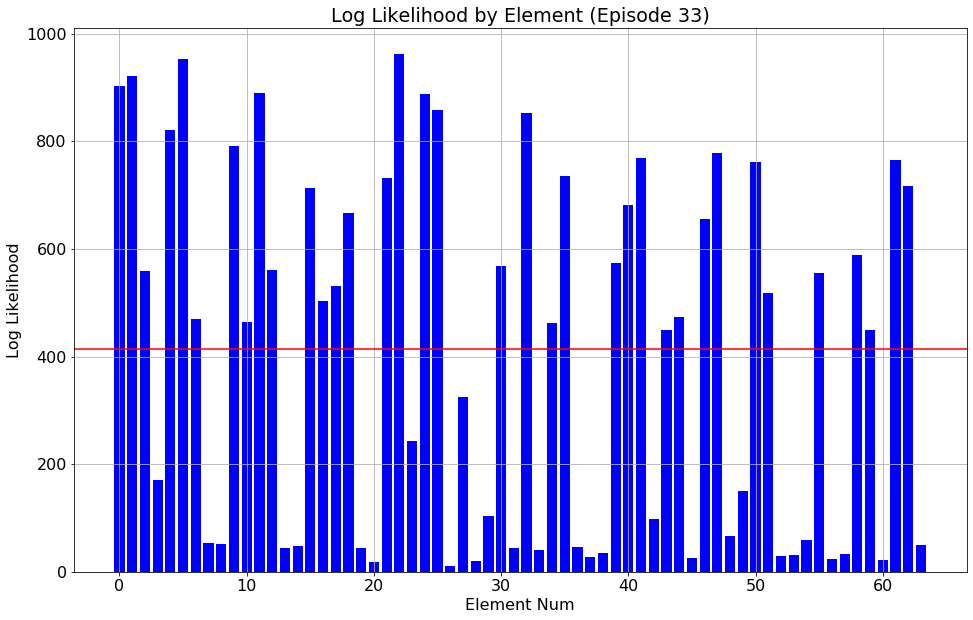

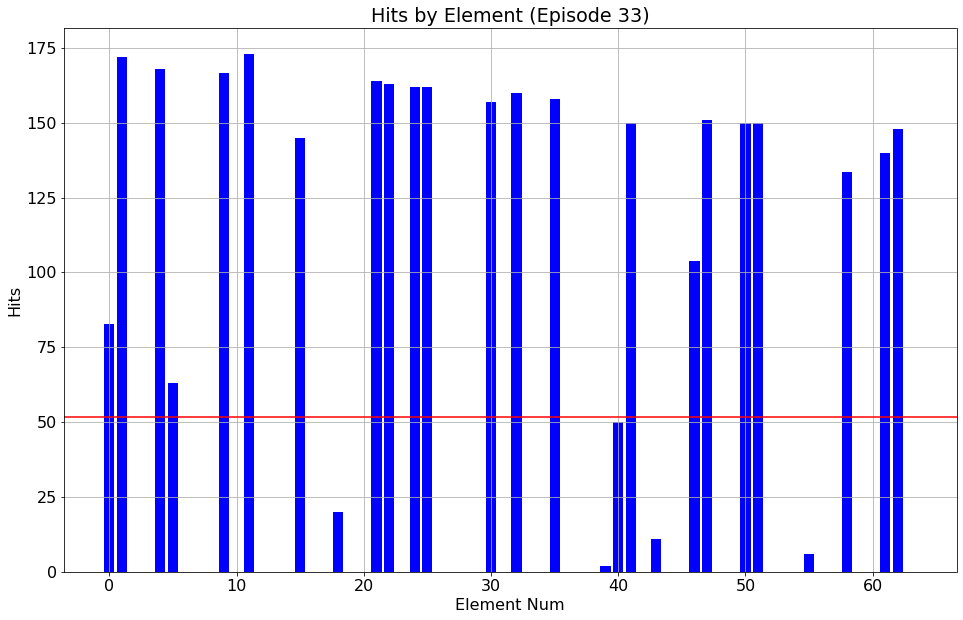


********************************************************************************
Round 8: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 33: Epoch  129, Batch   6450
effective_learning_rate=1.526e-05, training_time 278 sec.
Train on 3200 samples
Epoch 130/133
3200/3200 [==============================] - 4s 1ms/sample - loss: inf
Adjusted element weight down on 23 candidate elements. Mean weight = 8.20e-01
                    \  All Elts : Bad Elts : Good Elts (26)
Geom Mean Resolution:     89.44 :   216.53 :    24.57 arc seconds
Geom Mean Threshold :   1001.71 :  1876.22 :   400.32 arc seconds
Mean Log Likelihood :    414.55 :   186.80 :   747.41
Mean Hits           :     54.23 :     0.21 :   133.19
Good Elements       :     26.00

Training episode 34: Epoch  130, Batch   6500
effective_learning_rate=1.252e-05, training_time 284 

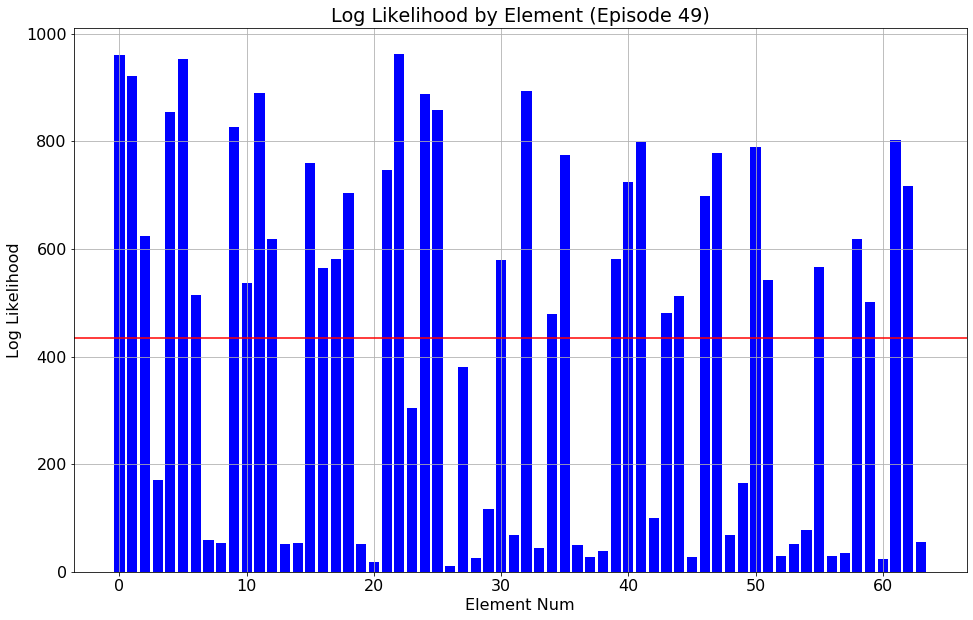

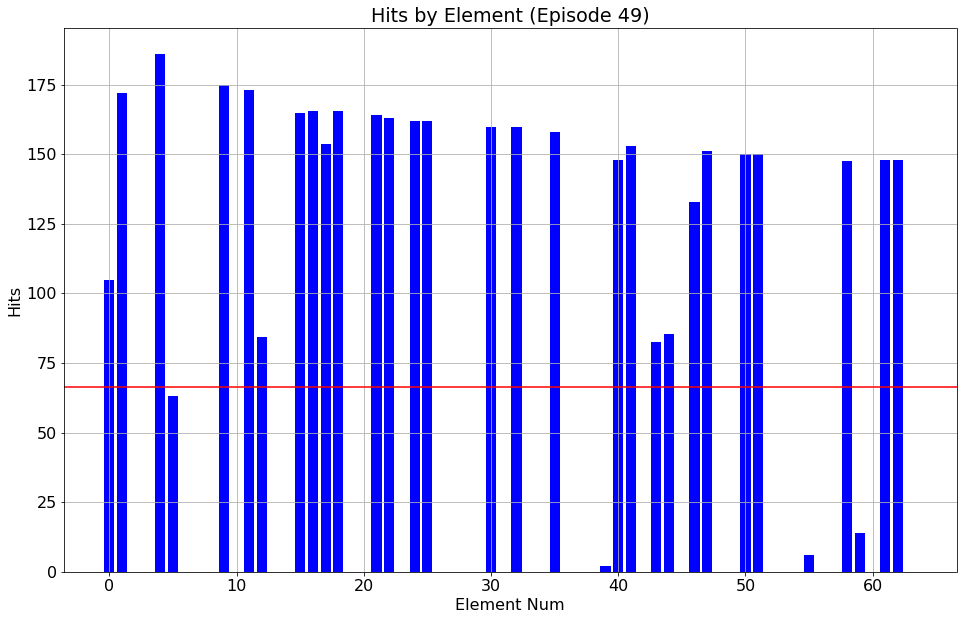


********************************************************************************
Round 9: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 49: Epoch  162, Batch   8100
effective_learning_rate=6.020e-06, training_time 372 sec.
Train on 3200 samples
Epoch 163/166
3200/3200 [==============================] - 3s 1ms/sample - loss: -7010199132.1600
Epoch 164/166
3200/3200 [==============================] - 2s 575us/sample - loss: -8160510525.4400
Epoch 165/166
3200/3200 [==============================] - 2s 575us/sample - loss: -9596361256.9600
Epoch 166/166
3200/3200 [==============================] - 2s 585us/sample - loss: -11382714736.6400
Adjusted element weight down on 9 candidate elements. Mean weight = 8.71e-01
                    \  All Elts : Bad Elts : Good Elts (35)
Geom Mean Resolution:     68.21 :   278.47 :    21.26 arc seconds
Geom Mean Threshold :    730.15 :  

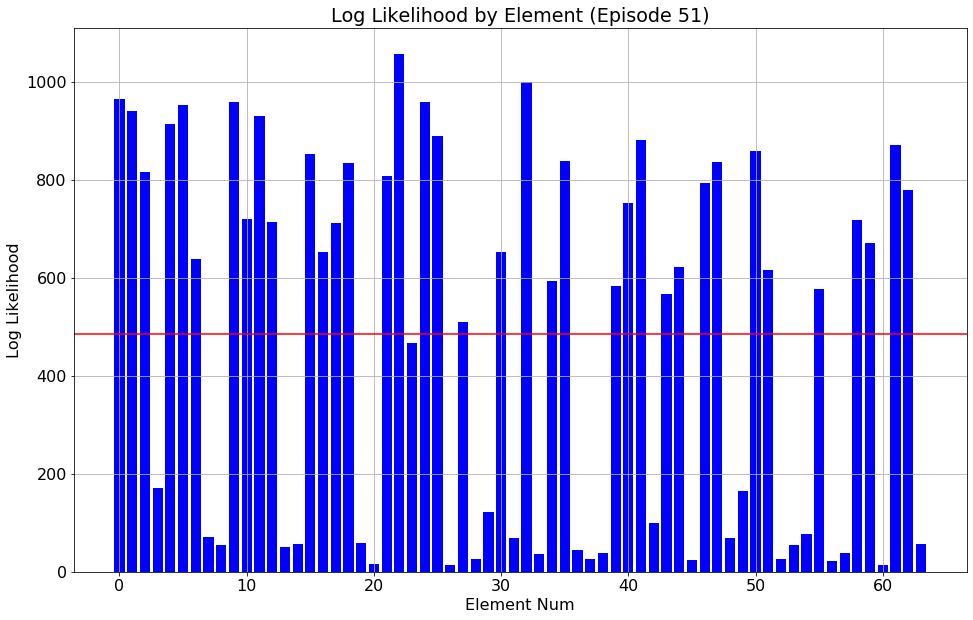

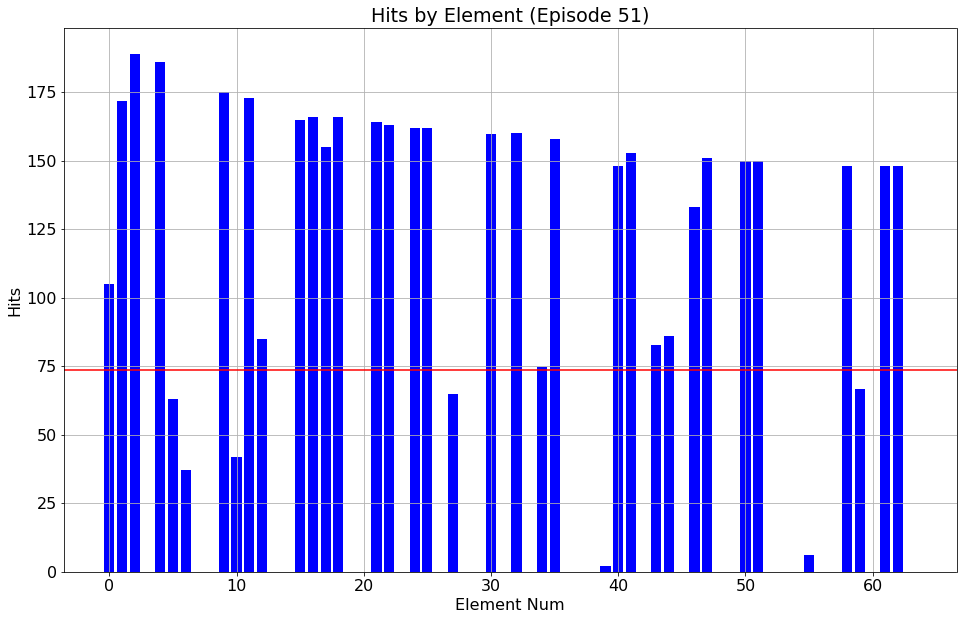


********************************************************************************
Round 10: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 51: Epoch  170, Batch   8500
effective_learning_rate=2.041e-04, training_time 391 sec.
Train on 3200 samples
Epoch 171/174
3200/3200 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 45 candidate elements. Mean weight = 2.87e-01
                    \  All Elts : Bad Elts : Good Elts (35)
Geom Mean Resolution:     52.64 :   279.64 :    13.20 arc seconds
Geom Mean Threshold :    582.81 :  1842.25 :   224.59 arc seconds
Mean Log Likelihood :    485.34 :   109.33 :   796.89
Mean Hits           :     76.53 :     0.28 :   139.70
Good Elements       :     35.00

Training episode 52: Epoch  171, Batch   8550
effective_learning_rate=4.382e-06, training_time 397

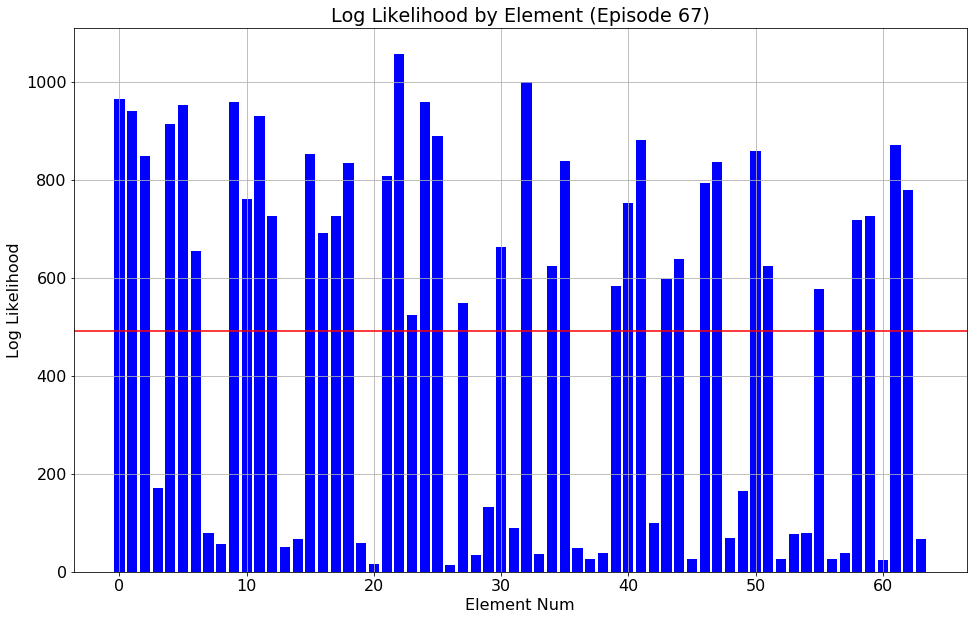

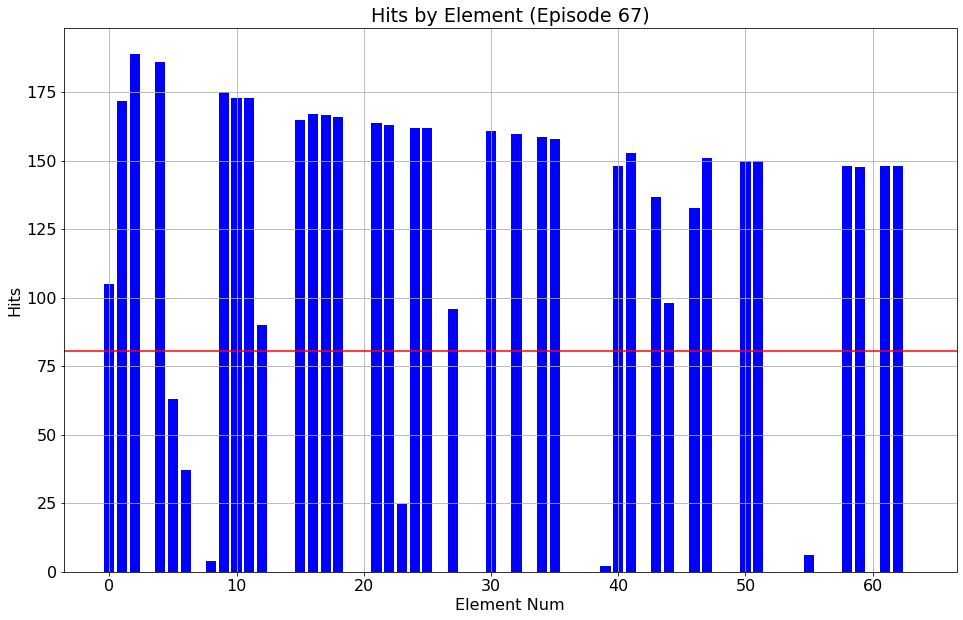


********************************************************************************
Round 11: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 1800.0
********************************************************************************

Training episode 67: Epoch  201, Batch  10050
effective_learning_rate=1.281e-06, training_time 486 sec.
Train on 3200 samples
Epoch 202/205
3200/3200 [==============================] - 4s 1ms/sample - loss: -29250519982.0800
Epoch 203/205
3200/3200 [==============================] - 2s 632us/sample - loss: -33530061332.4800
Epoch 204/205
3200/3200 [==============================] - 2s 634us/sample - loss: -38726548848.6400
Epoch 205/205
3200/3200 [==============================] - 2s 639us/sample - loss: -45067127848.9600
Adjusted element weight down on 18 candidate elements. Mean weight = 7.66e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     43.64 :   291.64 :     9.96 arc seconds
Geom Mean Threshold :    457.3

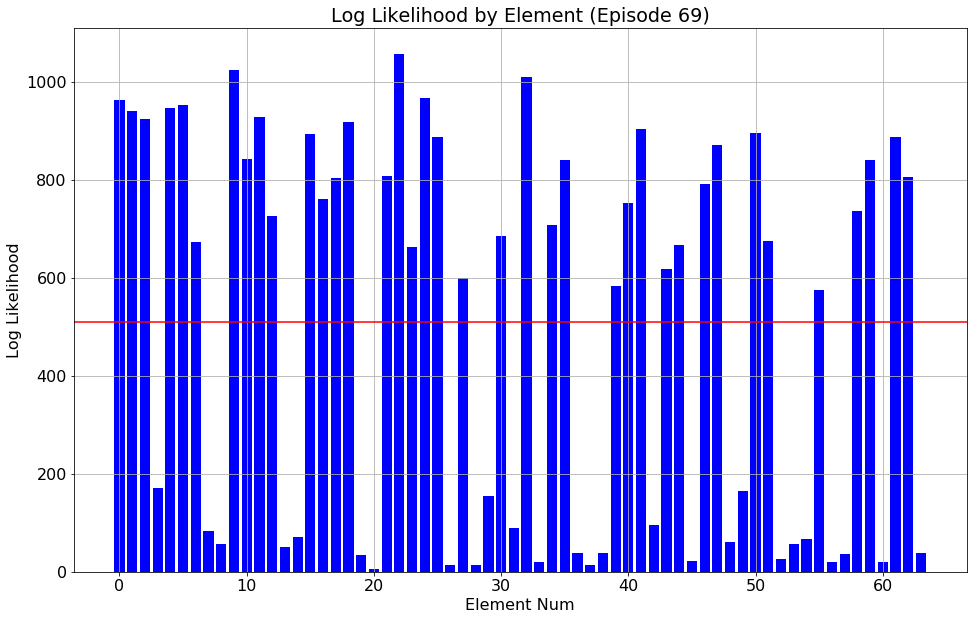

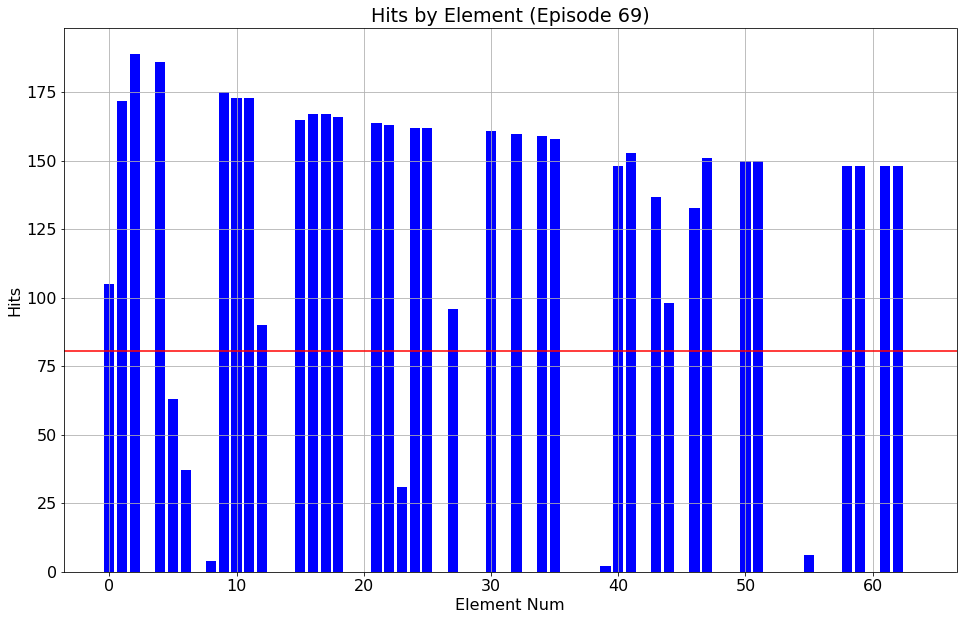


********************************************************************************
Round 12: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 69: Epoch  209, Batch  10450
effective_learning_rate=1.593e-04, training_time 507 sec.
Train on 3200 samples
Epoch 210/213
3200/3200 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 52 candidate elements. Mean weight = 4.35e-02
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     38.58 :   300.90 :     7.81 arc seconds
Geom Mean Threshold :    410.27 :  1511.35 :   148.81 arc seconds
Mean Log Likelihood :    510.36 :    95.07 :   833.37
Mean Hits           :     80.74 :     0.43 :   143.21
Good Elements       :     36.00

Training episode 70: Epoch  210, Batch  10500
effective_learning_rate=6.630e-07, training_time 513

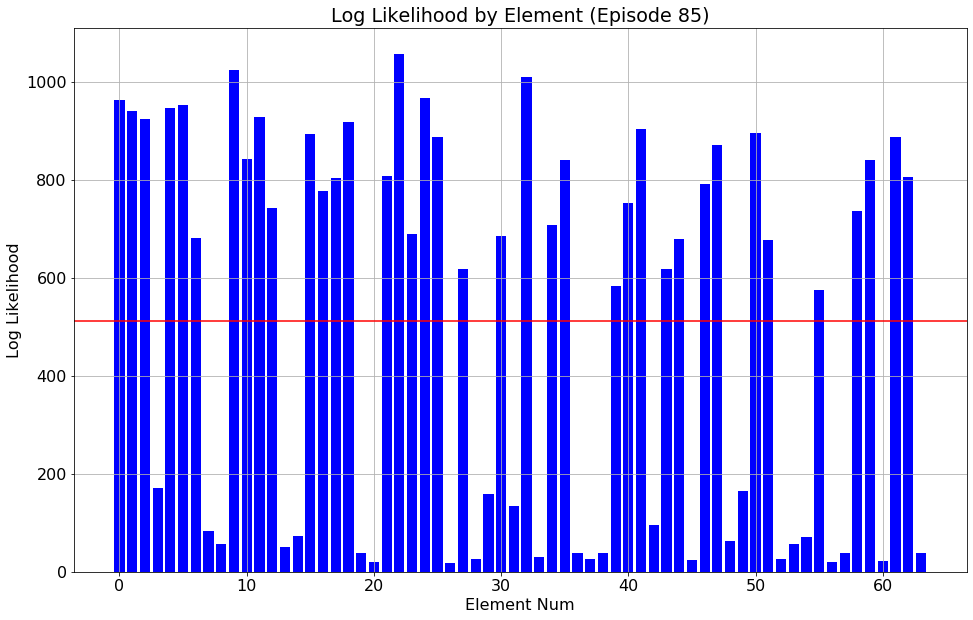

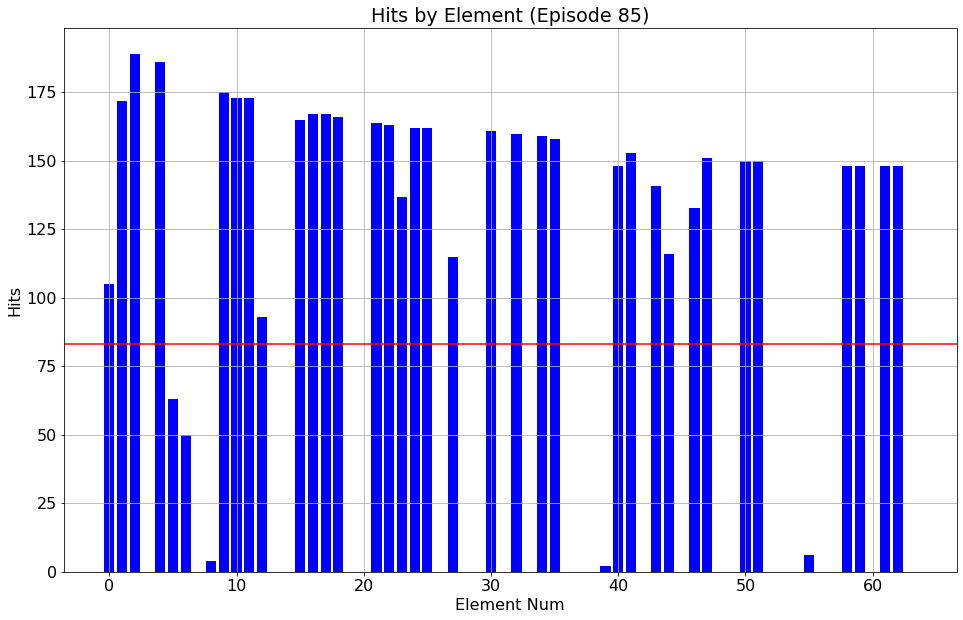


********************************************************************************
Round 7: 1000 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 400.0
********************************************************************************

Training episode 85: Epoch  240, Batch  12000
effective_learning_rate=2.441e-04, training_time 615 sec.
Train on 3200 samples
Epoch 241/244
3200/3200 [==============================] - 5s 2ms/sample - loss: -72383149670.4000
Epoch 242/244
3200/3200 [==============================] - 3s 823us/sample - loss: -79619756687.3600
Epoch 243/244
3200/3200 [==============================] - 3s 860us/sample - loss: -87826140364.8000
Epoch 244/244
3200/3200 [==============================] - 3s 888us/sample - loss: -97163386716.1600
Adjusted element weight down on 28 candidate elements. Mean weight = 7.81e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     25.12 :   142.43 :     6.51 arc seconds
Geom Mean Threshold :    212.05

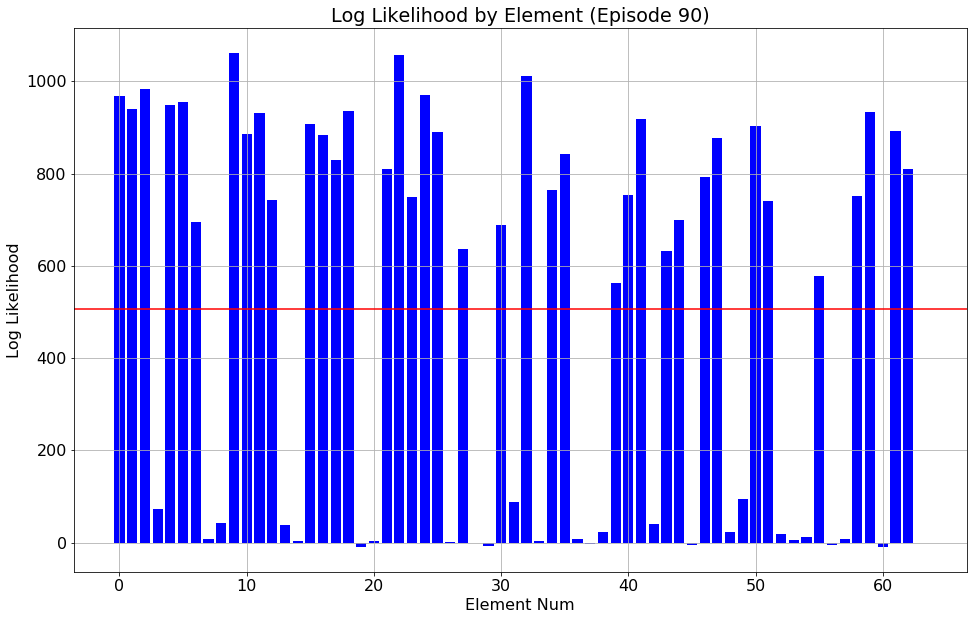

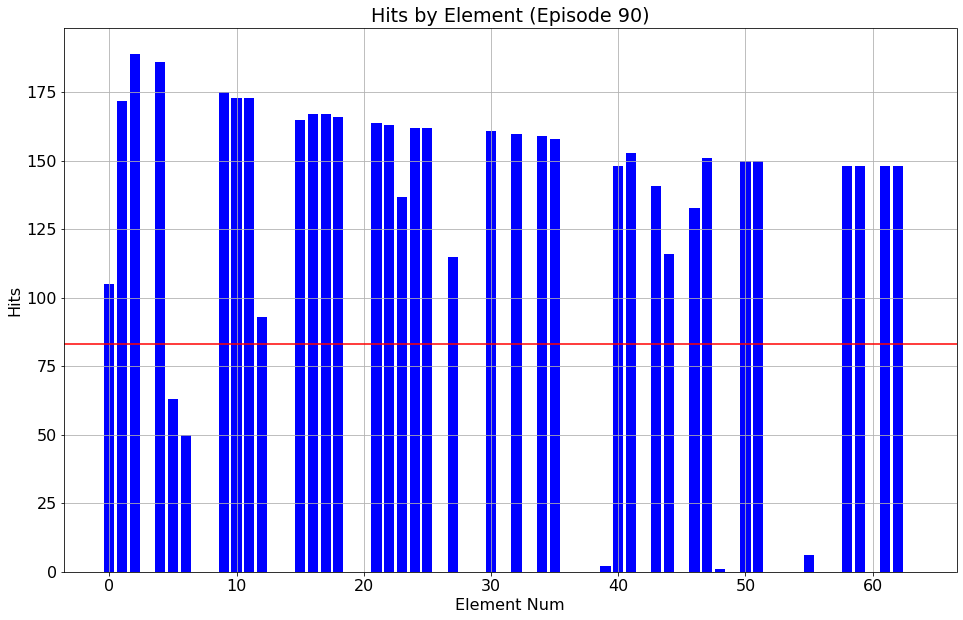


********************************************************************************
Round 8: 4000 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 90: Epoch  260, Batch  13000
effective_learning_rate=3.815e-06, training_time 677 sec.
Train on 3200 samples
Epoch 261/264
3200/3200 [==============================] - 7s 2ms/sample - loss: inf
Adjusted element weight down on 26 candidate elements. Mean weight = 7.97e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     21.33 :   140.25 :     4.93 arc seconds
Geom Mean Threshold :    189.11 :   394.72 :   106.70 arc seconds
Mean Log Likelihood :    512.17 :    60.82 :   863.21
Mean Hits           :     84.89 :     0.32 :   150.66
Good Elements       :     36.00

Training episode 91: Epoch  261, Batch  13050
effective_learning_rate=3.040e-06, training_time 686 

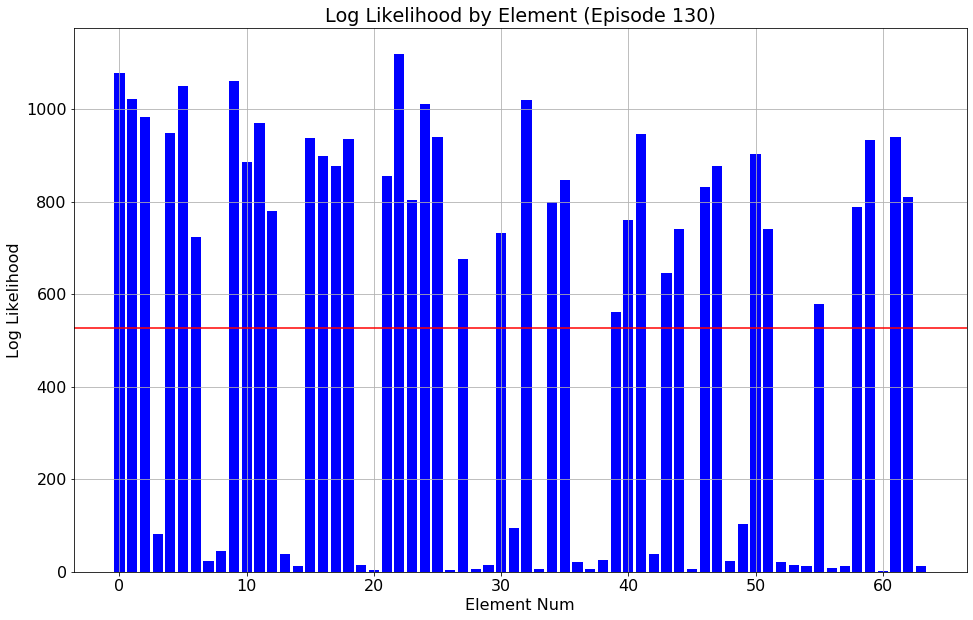

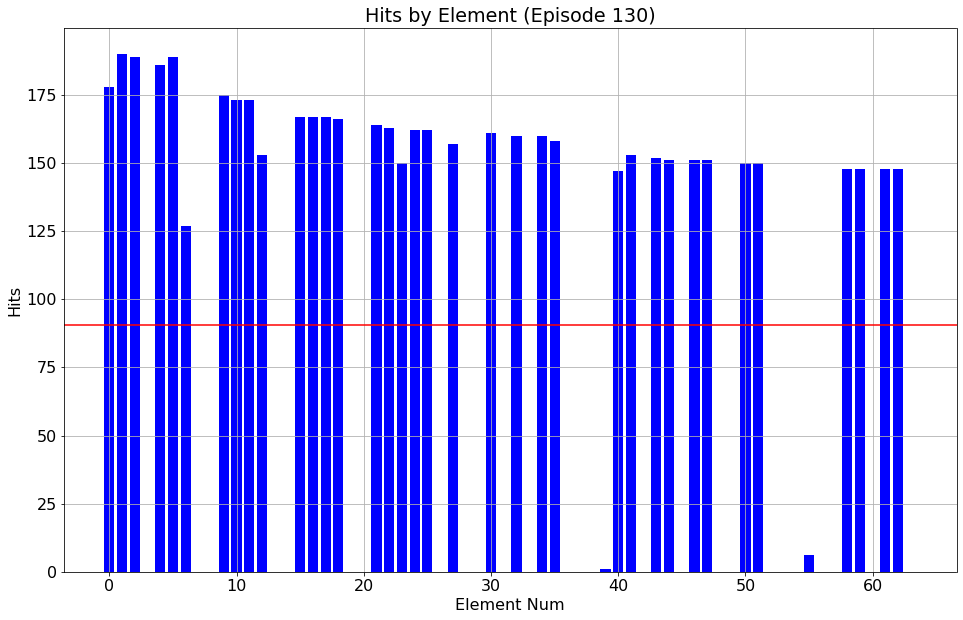


********************************************************************************
Round 9: 2000 batches @ LR 2^-12 in mixture mode.
********************************************************************************

Training episode 130: Epoch  339, Batch  16950
effective_learning_rate=2.441e-04, training_time 1019 sec.
Train on 3200 samples
Epoch 340/343
3200/3200 [==============================] - 5s 2ms/sample - loss: -161224049295.3600
Epoch 341/343
3200/3200 [==============================] - 3s 983us/sample - loss: -177020812656.6400
Epoch 342/343
3200/3200 [==============================] - 3s 1ms/sample - loss: -194922023813.1200
Epoch 343/343
3200/3200 [==============================] - 3s 977us/sample - loss: -215195146321.9200
Adjusted element weight down on 30 candidate elements. Mean weight = 7.66e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     18.61 :   131.13 :     4.07 arc seconds
Geom Mean Threshold :    173.61 :   386.66 :    93

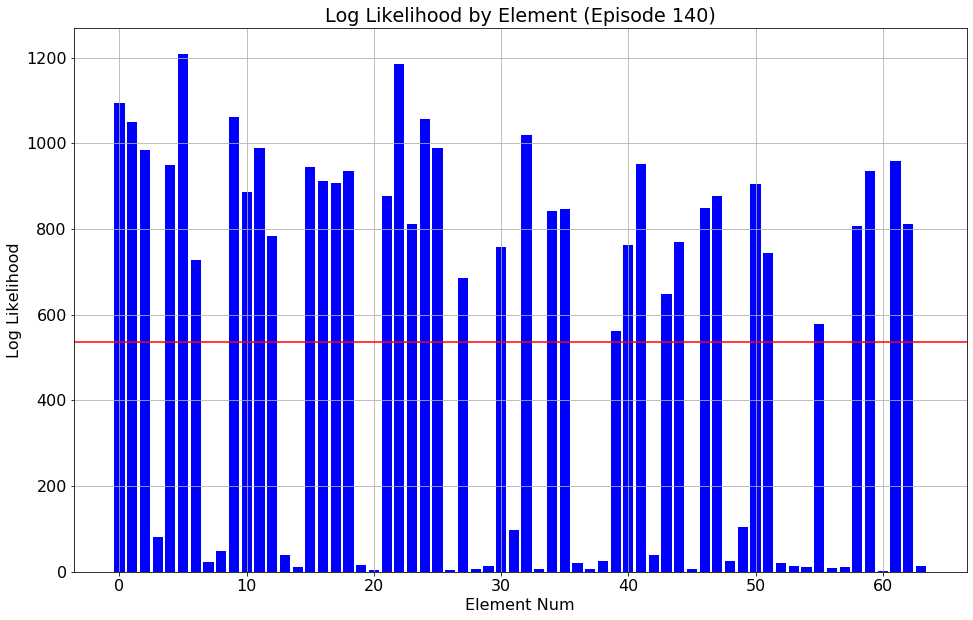

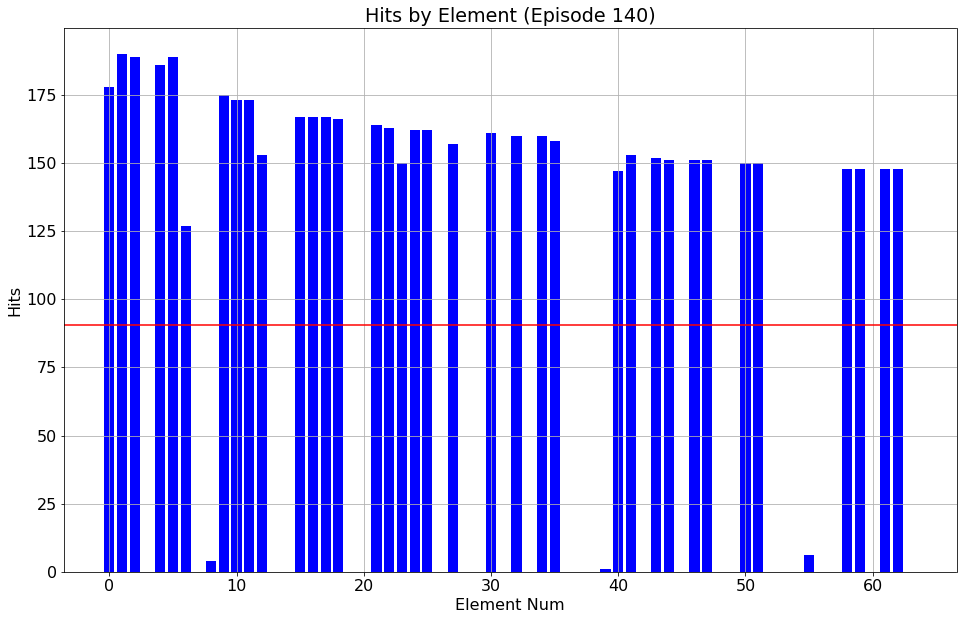

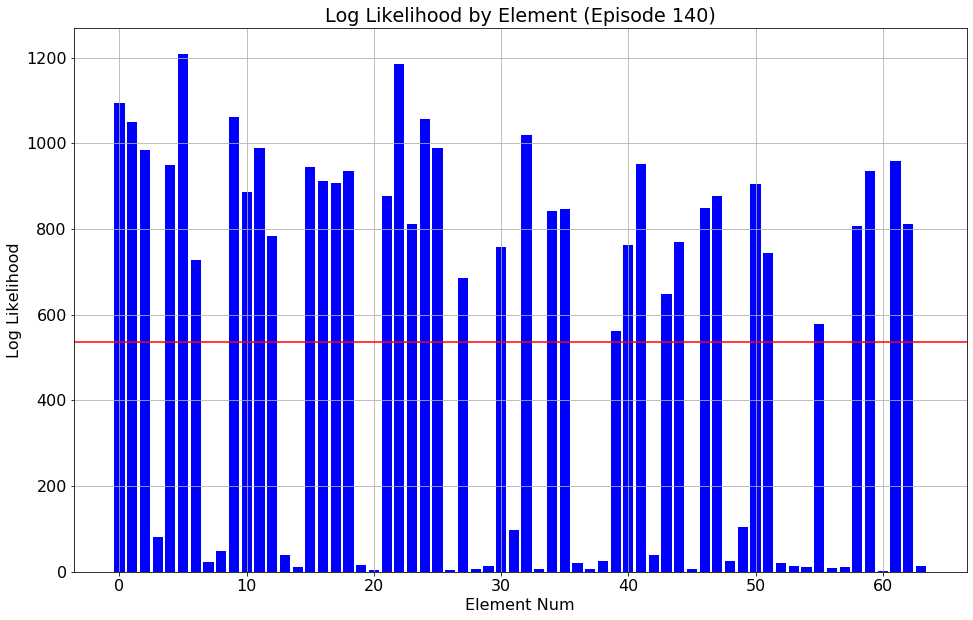

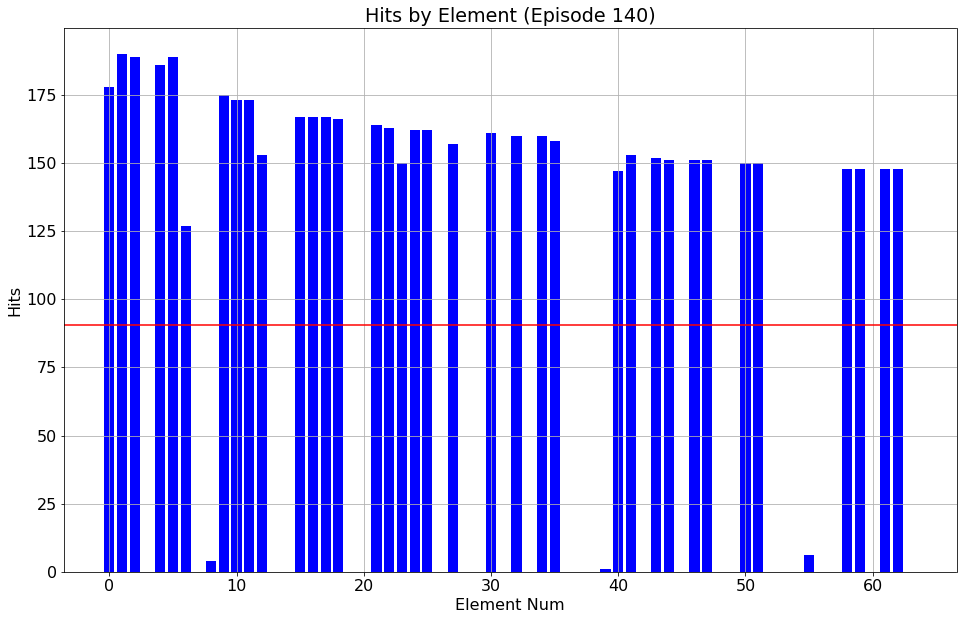

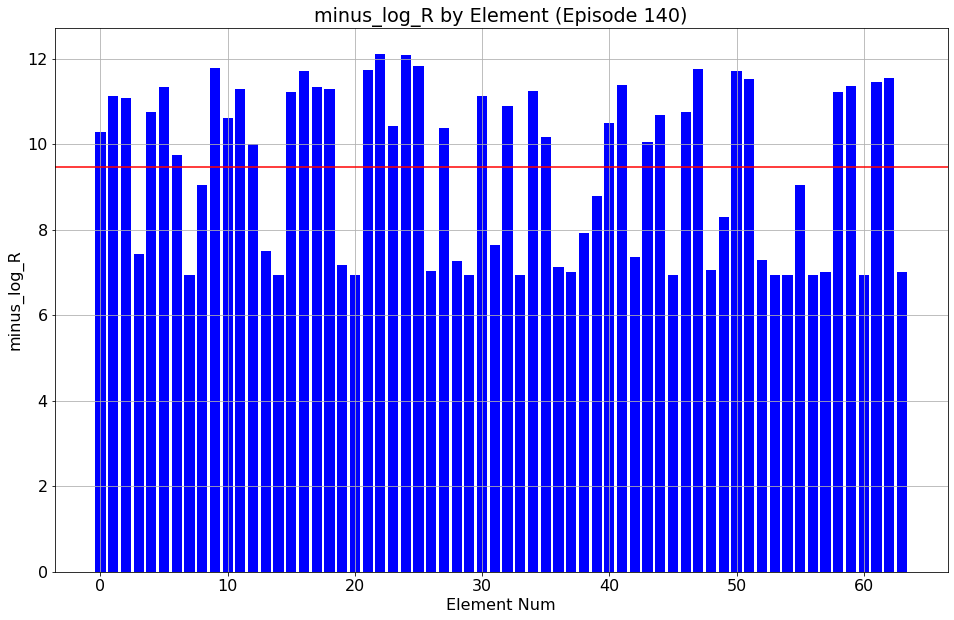

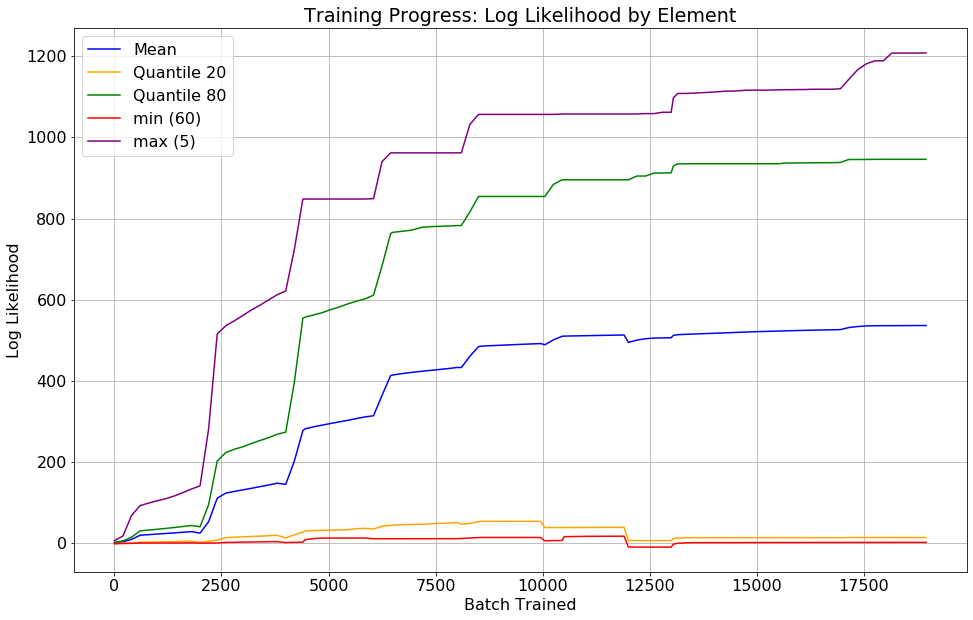

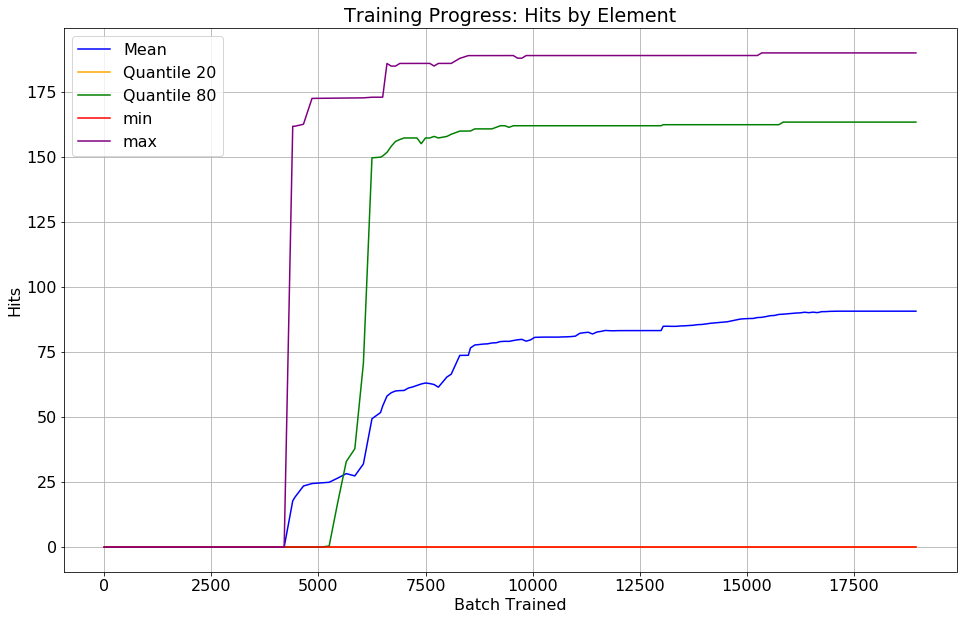

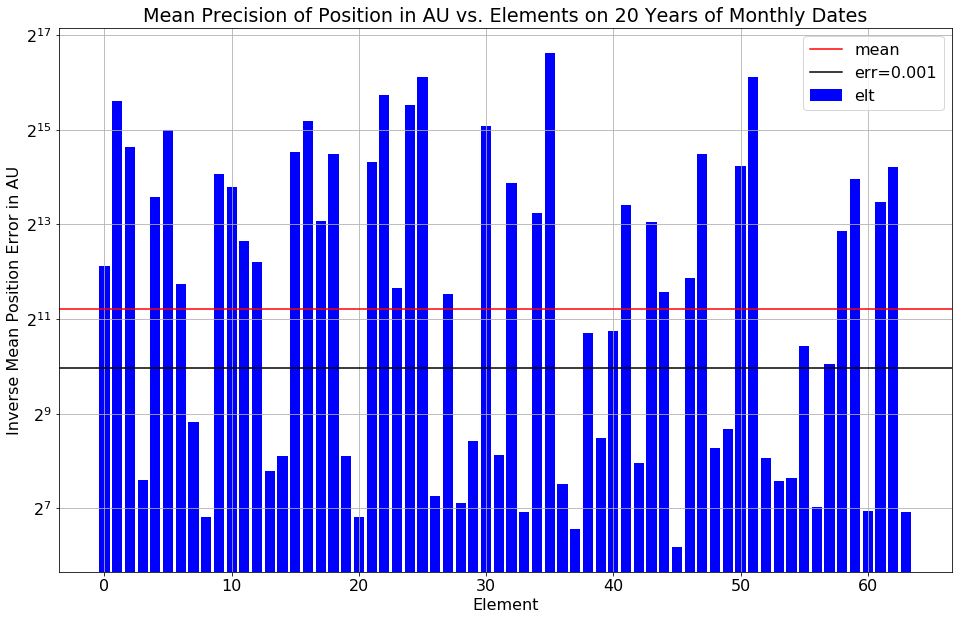

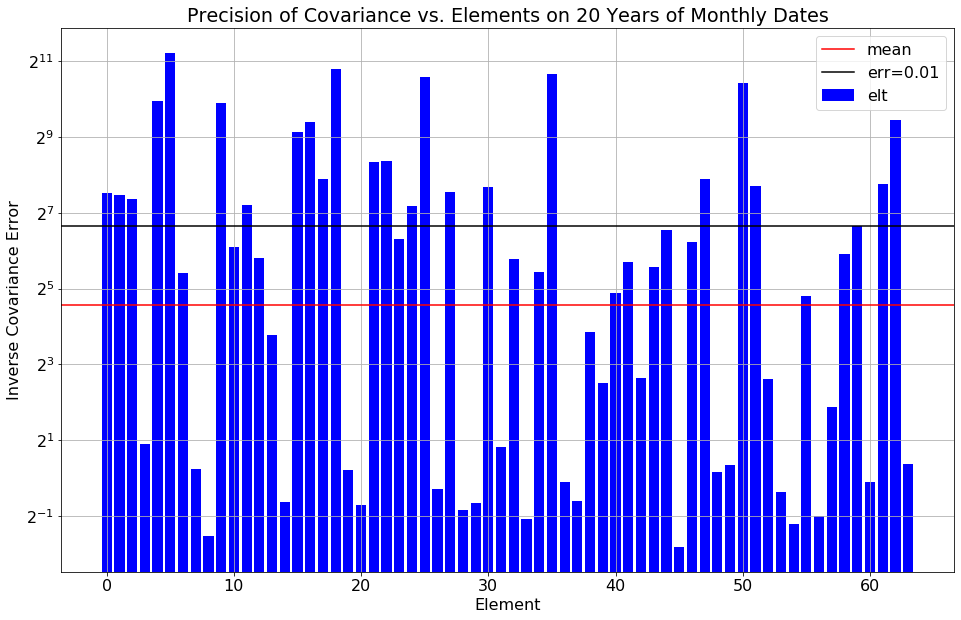

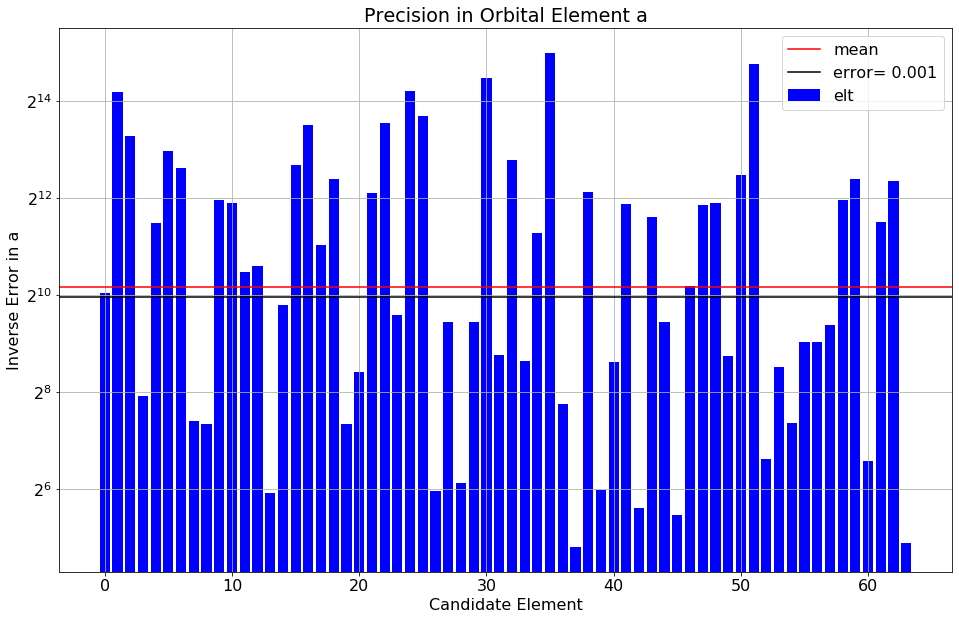

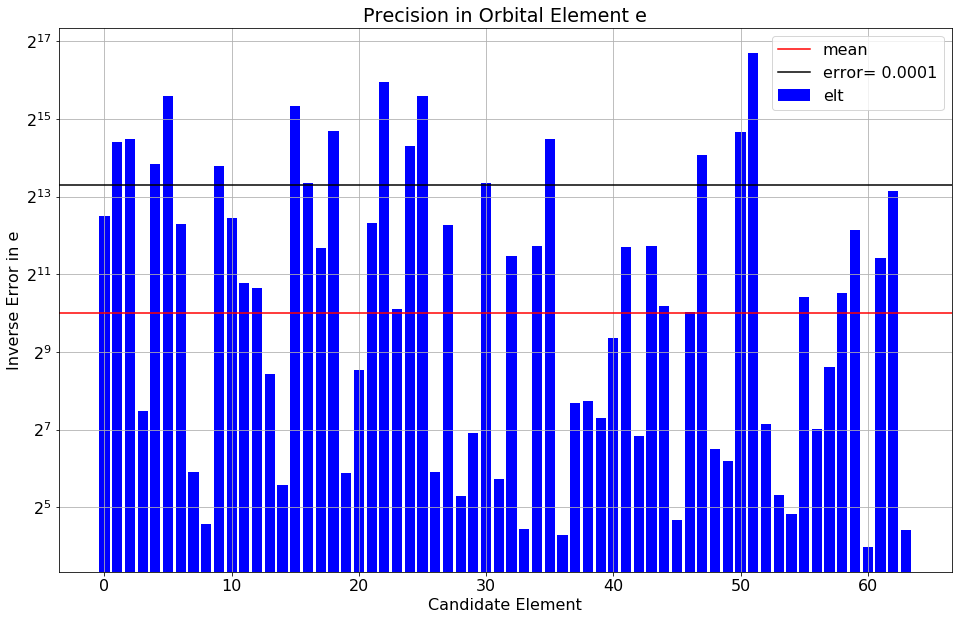

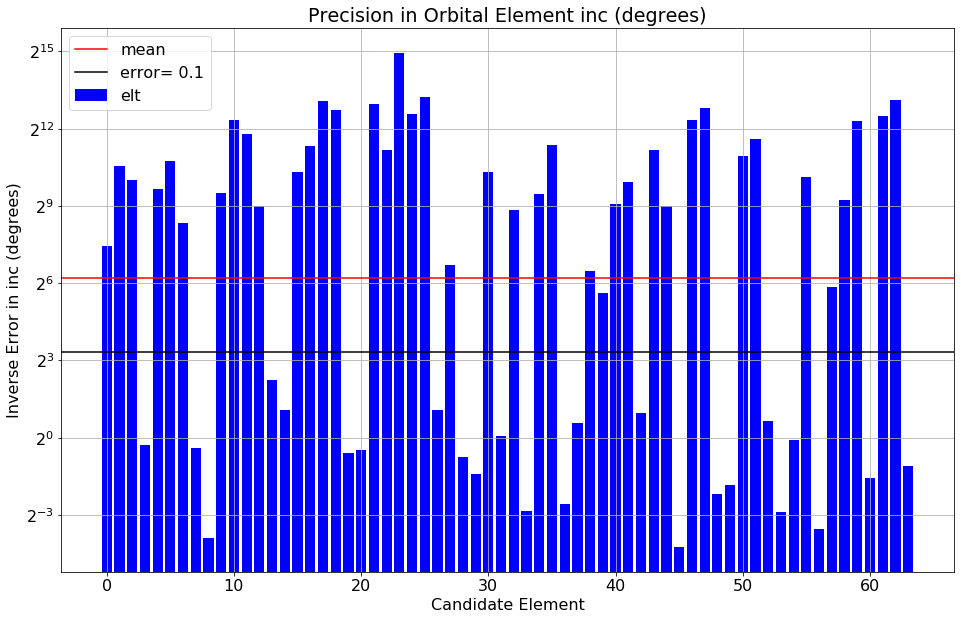

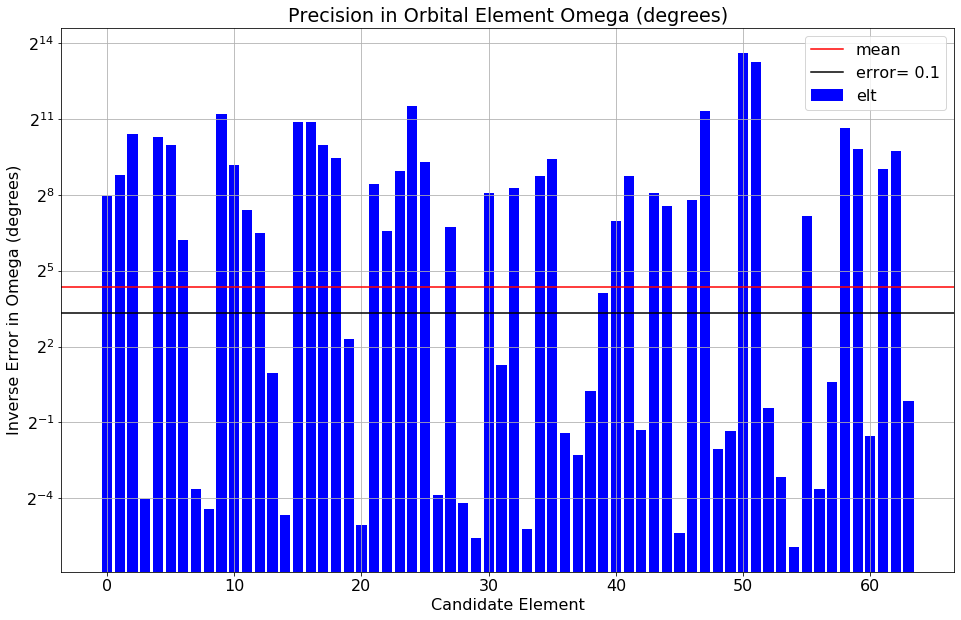

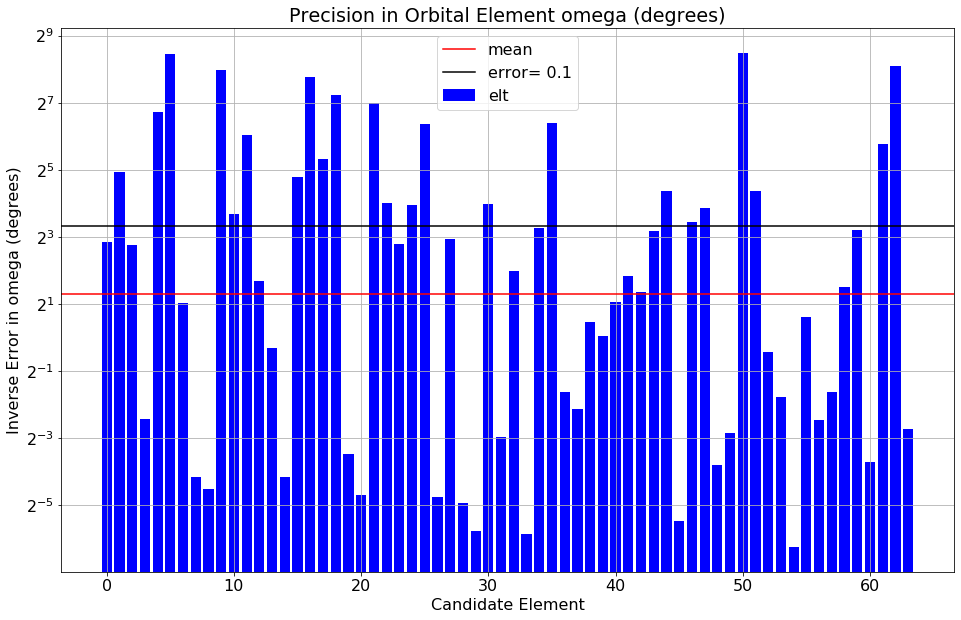

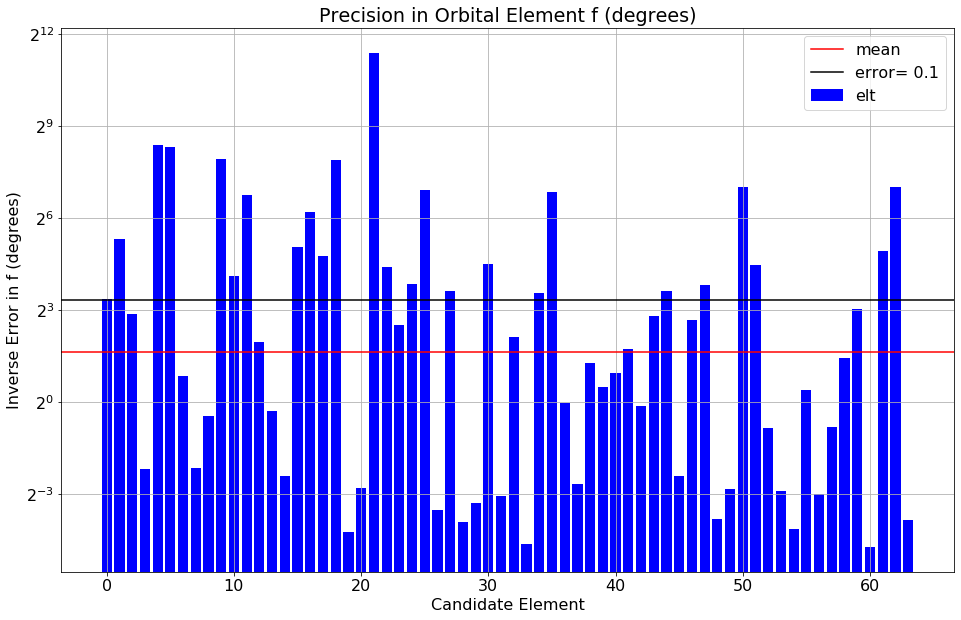

In [32]:
model.sieve()

In [33]:
model.report()


Good elements (hits >= 10):  36.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   903.49  : 160.94 :     3.80 :    85.00
Mean Bad :    64.40  :   0.39 :   150.05 :   386.56
Mean     :   536.39  :  90.70 :    67.78 :   216.93
Median   :   750.39  : 148.00 :     7.48 :   149.32
GeoMean  :   170.82  :  17.65 :    18.10 :   157.33
Min      :     2.03  :   0.00 :     1.14 :    29.52
Max      :  1208.18  : 190.00 :   200.00 :   400.00
Trained for 18950 batches over 379 epochs and 140 episodes (elapsed time 1154 seconds).


In [34]:
model.report()


Good elements (hits >= 10):  36.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   903.49  : 160.94 :     3.80 :    85.00
Mean Bad :    64.40  :   0.39 :   150.05 :   386.56
Mean     :   536.39  :  90.70 :    67.78 :   216.93
Median   :   750.39  : 148.00 :     7.48 :   149.32
GeoMean  :   170.82  :  17.65 :    18.10 :   157.33
Min      :     2.03  :   0.00 :     1.14 :    29.52
Max      :  1208.18  : 190.00 :   200.00 :   400.00
Trained for 18950 batches over 379 epochs and 140 episodes (elapsed time 1154 seconds).


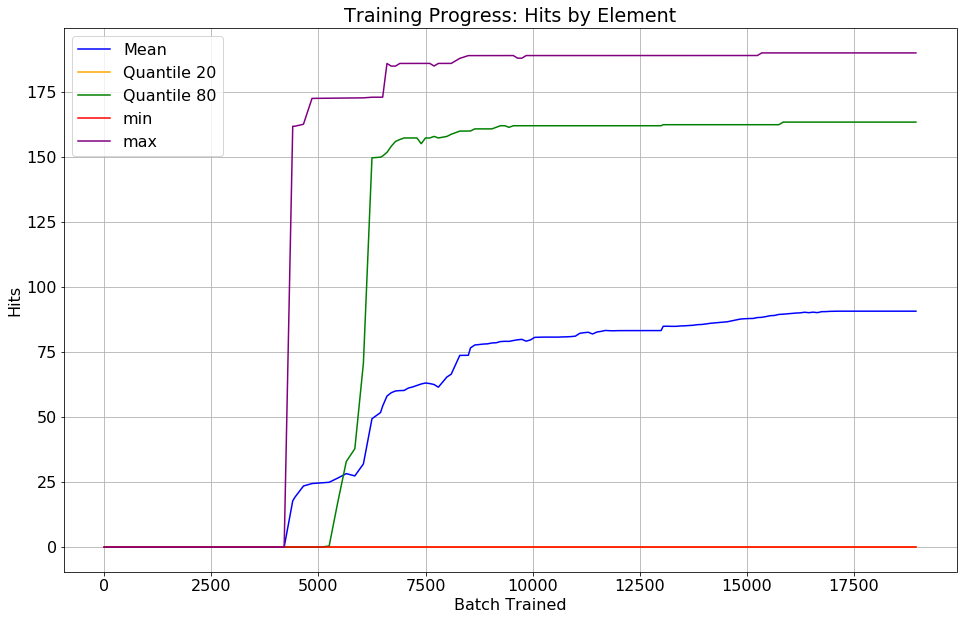

(<Figure size 1152x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2bb3323050>)

In [35]:
model.plot_hist('hits')

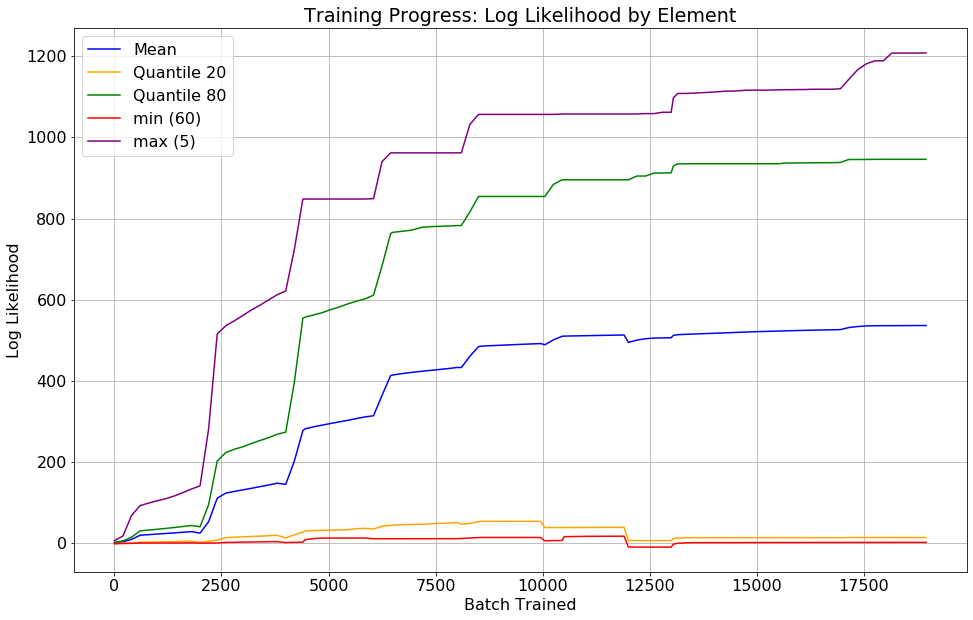

(<Figure size 1152x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2bc846ebd0>)

In [36]:
model.plot_hist('log_like')

## Distance vs. Nearest Asteroid for Fitted Elements

In [37]:
_ = model.nearest_ast()

In [38]:
model.report()


Good elements (hits >= 10):  36.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   903.49  : 160.94 :     3.80 :    85.00
Mean Bad :    64.40  :   0.39 :   150.05 :   386.56
Mean     :   536.39  :  90.70 :    67.78 :   216.93
Median   :   750.39  : 148.00 :     7.48 :   149.32
GeoMean  :   170.82  :  17.65 :    18.10 :   157.33
Min      :     2.03  :   0.00 :     1.14 :    29.52
Max      :  1208.18  : 190.00 :   200.00 :   400.00
Trained for 18950 batches over 379 epochs and 140 episodes (elapsed time 1154 seconds).


In [39]:
# model.save_state()

In [40]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 36 asteroids.
Mean on converged asteroids:
Number of hits         : 160.94
GeoMean Distance in AU : 7.08e-05
Covariance norm        : 8.59e-03


In [41]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
1,59244,1049.783691,190.000000,3.018776,70.725250,59244,0.000020,0.005661
5,5817,1208.177368,189.000000,2.474024,77.836098,5817,0.000031,0.000419
2,15786,984.829895,189.000000,3.153692,55.105259,15786,0.000039,0.006098
4,142999,949.013184,185.986816,4.453819,91.566582,142999,0.000082,0.001011
0,51921,1094.216553,177.997055,7.018981,159.574692,51921,0.000225,0.005427
9,14348,1062.138062,175.000000,1.574115,56.189575,14348,0.000058,0.001051
11,9936,988.108521,173.000000,2.597166,75.357201,9936,0.000155,0.006727
10,43796,886.588379,173.000000,5.064700,90.388443,43796,0.000070,0.014676
16,48453,912.262512,167.000000,1.677080,29.520824,48453,0.000027,0.001492
17,53516,906.893372,167.000000,2.480458,62.397846,53516,0.000116,0.004233


In [42]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [43]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
22,9229,166.197418,1.142445,70.060616,1185.167969,163.000000,0.000018,0.003046
24,2015,162.134903,1.169078,51.162251,1057.620728,162.000000,0.000021,0.006870
25,203722,164.617767,1.494061,50.844971,989.127625,162.000000,0.000014,0.000646
9,14348,177.639618,1.574115,56.189575,1062.138062,175.000000,0.000058,0.001051
47,733,152.677002,1.609424,50.422947,877.032349,151.000000,0.000044,0.004215
21,77774,165.690247,1.670688,40.550579,876.552246,164.000000,0.000049,0.003064
16,48453,169.948898,1.677080,29.520824,912.262512,167.000000,0.000027,0.001492
50,6455,151.625443,1.708304,51.980743,903.963745,150.000000,0.000052,0.000724
62,85937,150.063141,1.991396,49.565464,810.948059,148.000000,0.000053,0.001428
51,25318,152.389053,2.046256,35.691795,743.175293,150.000000,0.000014,0.004745


In [44]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

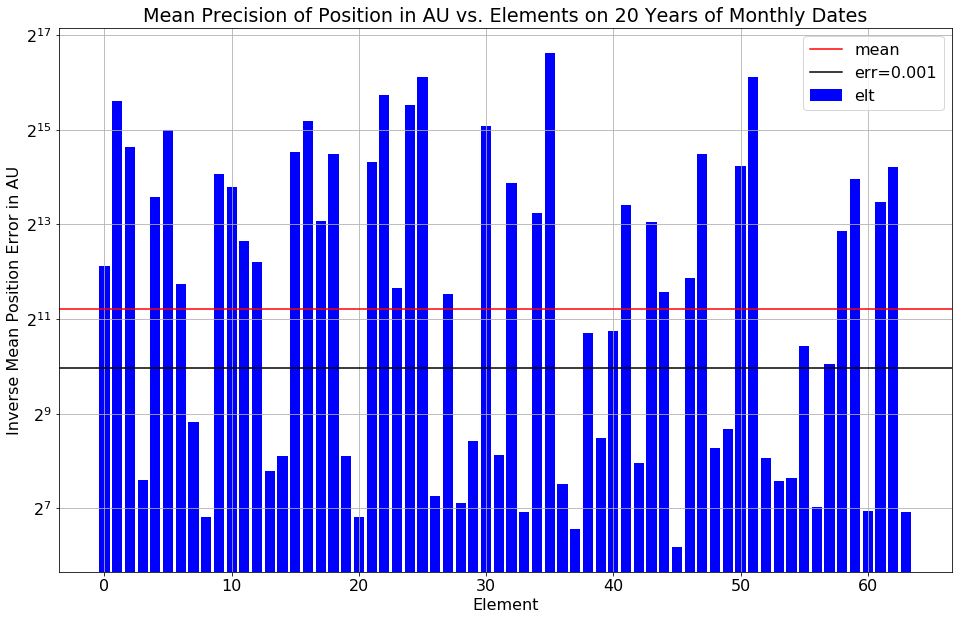

In [45]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

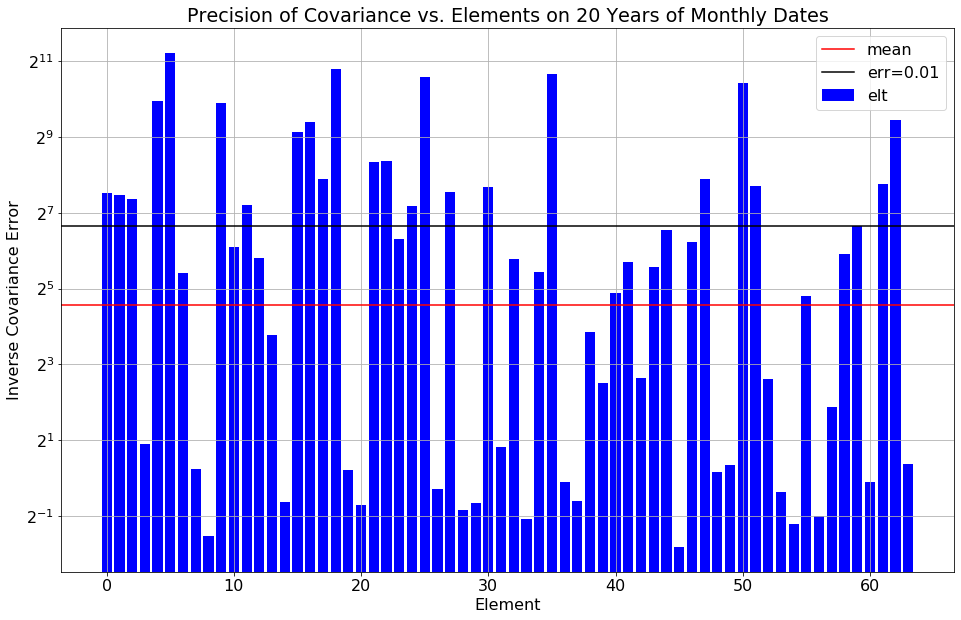

In [46]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

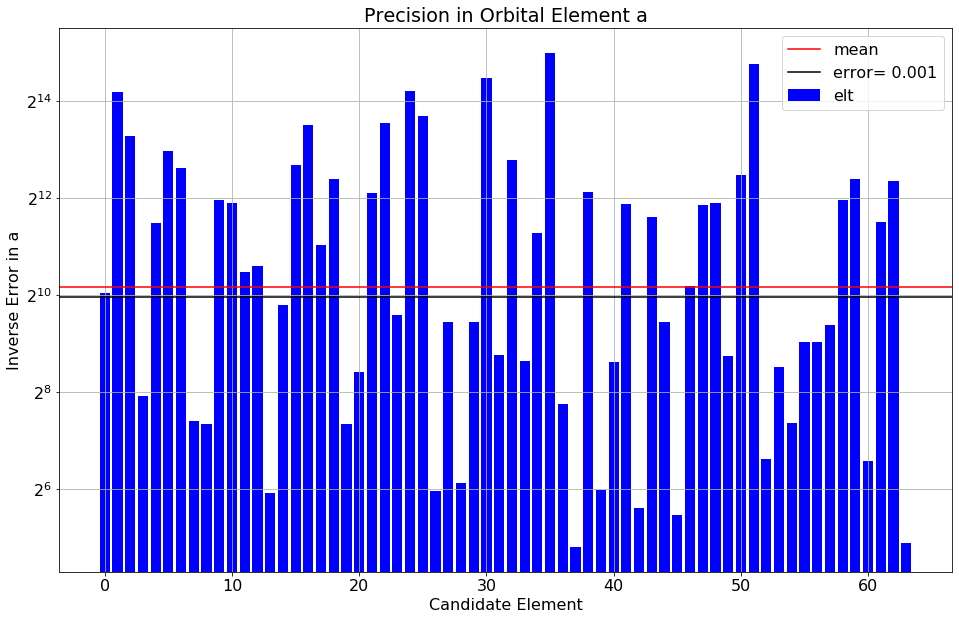

In [47]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

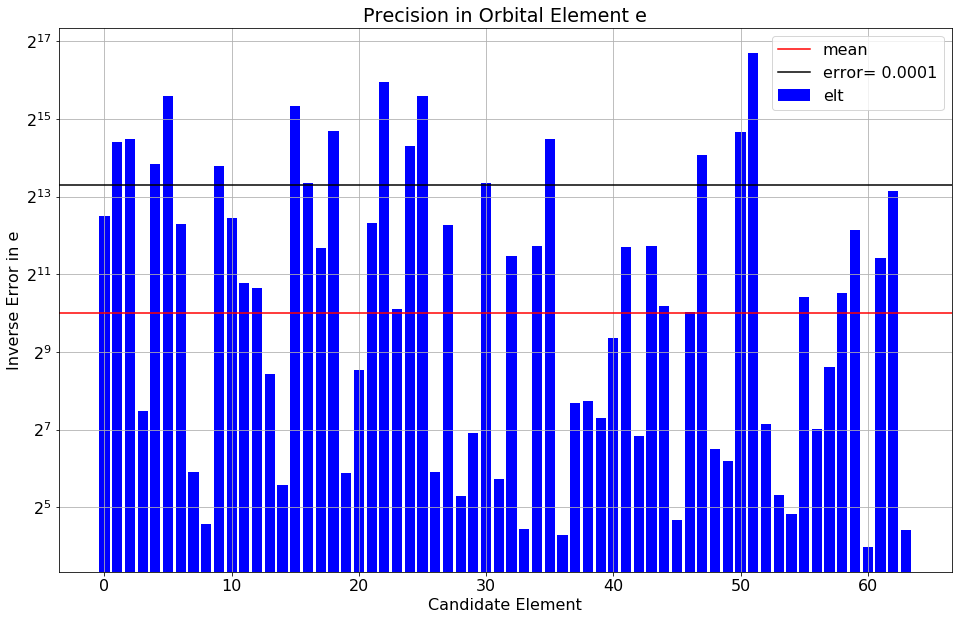

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

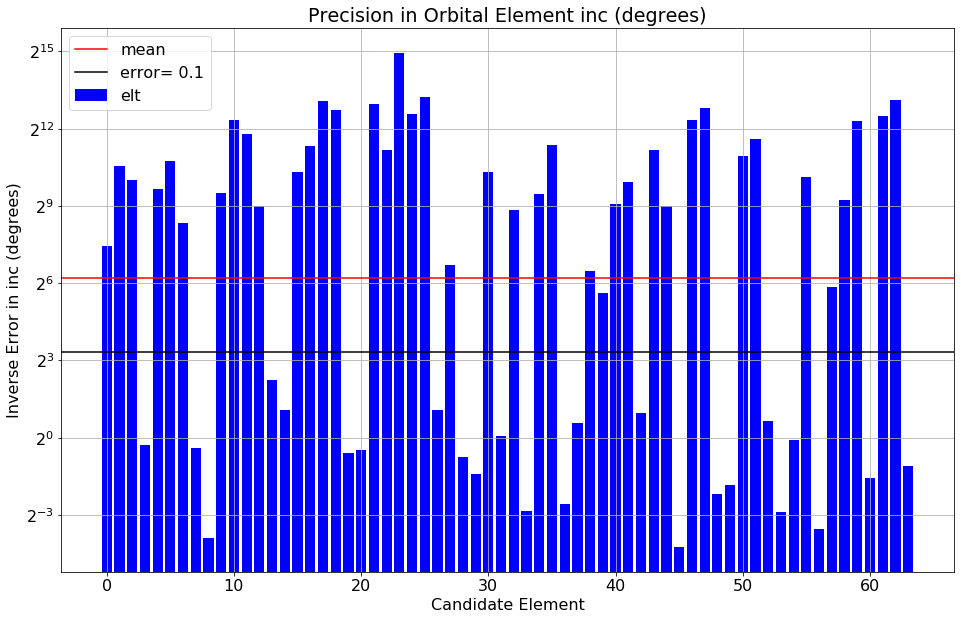

In [49]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

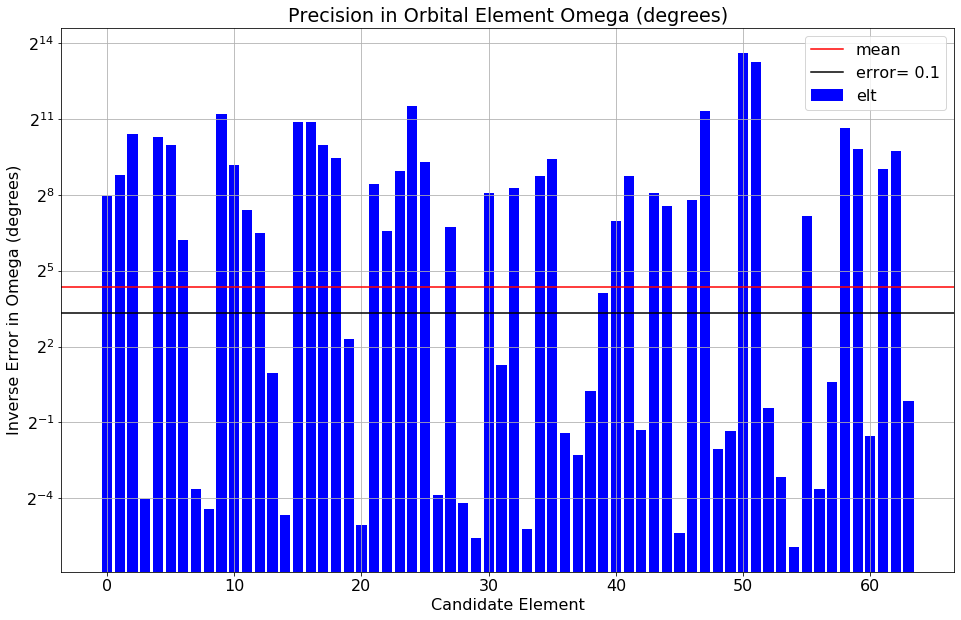

In [50]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

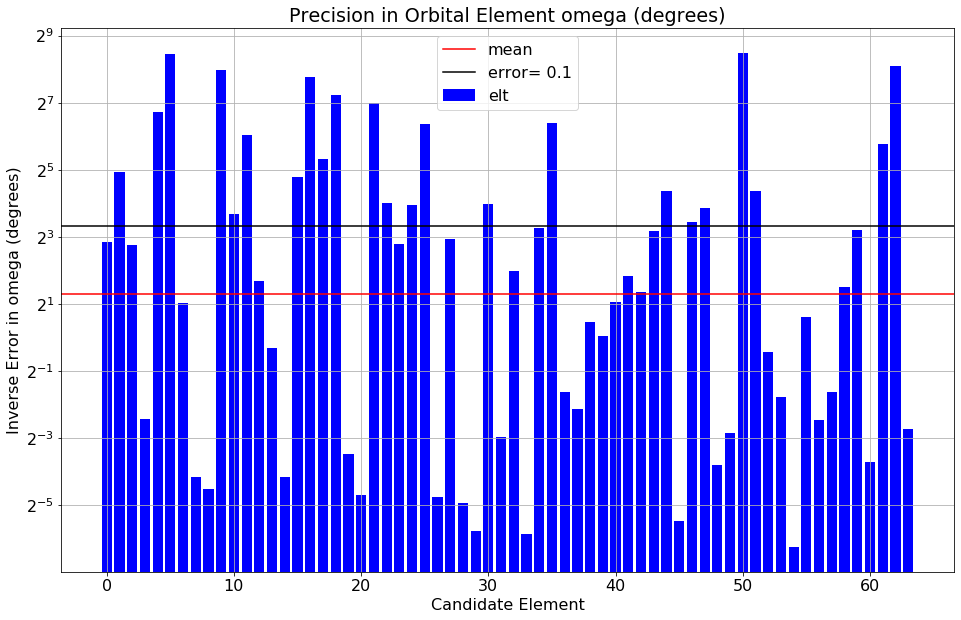

In [51]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

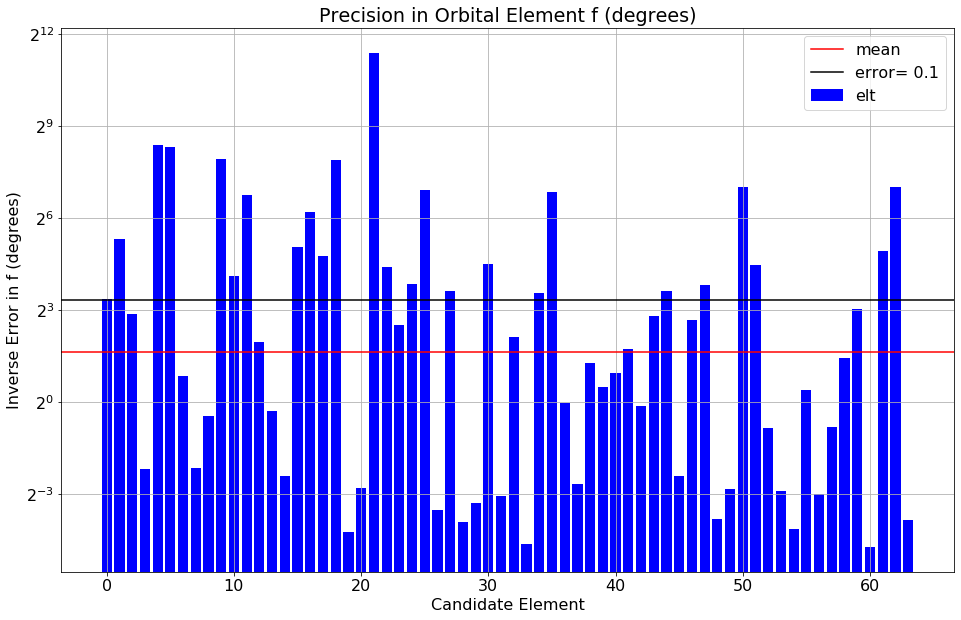

In [52]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)